# GPS/IMU Integration using Deep Kalman Filter

In this project, we are going to read the GPS and IMU data from KITTI dataset. The Kalman filter will be applied to integrate GPS and IMU at first. The deep learning will be applied to learn the IMU error model. The results of IMU positioning using Kalman filter will be compared with traditional Kalman filter. 

# 1- data preparation

## Readig KITTI information

In [1]:
import pykitti, cv2
import numpy as np
import matplotlib.pyplot as plt

Please put the directory of the KITTI dataset. 

In [2]:
# add your dataset directory
basedir = '/home/sia/Documents/KITTI'
date = '2011_09_26'
drive = '0005'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# Calibration, timestamps, and IMU data are read automatically. 
# Camera and velodyne data are available via properties that create generators
# when accessed, or through getter methods that provide random access.
data = pykitti.raw(basedir, date, drive)

1- Reading GPS data

In [3]:
dt_s = [o.second + 0.000001 * o.microsecond for o in data.timestamps]
dt_s[0:len(dt_s)]
dt =  0.1
lat_points = [o.packet.lat for o in data.oxts]
lon_points = [o.packet.lon for o in data.oxts]
alt_points = [o.packet.alt for o in data.oxts]

2- Reading IMU acceleration and angular rate

In [4]:
af_points = [o.packet.af for o in data.oxts]
al_points = [o.packet.al for o in data.oxts]
au_points = [o.packet.au for o in data.oxts]

In [5]:
wf_points = [o.packet.wf for o in data.oxts]
wl_points = [o.packet.wl for o in data.oxts]
wu_points = [o.packet.wu for o in data.oxts]

3- Reading velocity and heading. We use IMU observations to estimate position and heading. These information are applied to check if the estiamated velocities and orientation are correct.

In [6]:
#heading
h_points = [o.packet.yaw for o in data.oxts]
# velocities
ve_points = [o.packet.ve for o in data.oxts]
vn_points = [o.packet.vn for o in data.oxts]

##### Visualization

Now we visualize the trajectory. The cross shows the beginning of our trajectory

Text(0,0.5,'lat, deg')

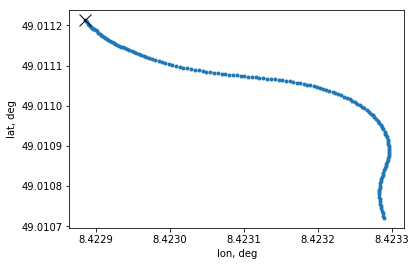

In [7]:
plt.plot(lon_points, lat_points,".")
plt.plot(lon_points[0], lat_points[0], 'kx', markersize=12)
plt.ticklabel_format(useOffset=False)
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")

### Creating training and testing data

We split our data into two categories: 1- When GPS is available and integration is possible. 2- When GPS is only available as ground truth and the error of visual and inertial odometry is estimated. 

In [8]:
traj_length=len(data.oxts)
test_ratio = 0.2
test_size = int (traj_length * test_ratio)
train_size= traj_length-test_size
print('trajectory points are: ', traj_length , '; training points are : ', train_size, '; training points are : ',test_size)
# training data
#GPS
train_lat_points=lat_points[:traj_length-test_size]
train_lon_points=lon_points[:traj_length-test_size]
train_alt_points=alt_points[:traj_length-test_size]
#IMU
train_af_points = af_points[:traj_length-test_size]
train_al_points = al_points[:traj_length-test_size]
train_au_points = au_points[:traj_length-test_size]
train_wf_points = wf_points[:traj_length-test_size]
train_wl_points = wl_points[:traj_length-test_size]
train_wu_points = wu_points[:traj_length-test_size]
#test data
test_lat_points=lat_points[traj_length-test_size:traj_length]
test_lon_points=lon_points[traj_length-test_size:traj_length]
test_alt_points=alt_points[traj_length-test_size:traj_length]
#IMU

test_af_points = af_points[traj_length-test_size+1:traj_length]
test_al_points = al_points[traj_length-test_size+1:traj_length]
test_au_points = au_points[traj_length-test_size+1:traj_length]
test_wf_points = wf_points[traj_length-test_size+1:traj_length]
test_wl_points = wl_points[traj_length-test_size+1:traj_length]
test_wu_points = wu_points[traj_length-test_size+1:traj_length]

trajectory points are:  154 ; training points are :  124 ; training points are :  30


##### Visualization

Let's visualize training and testing data

Text(0,0.5,'lat, deg')

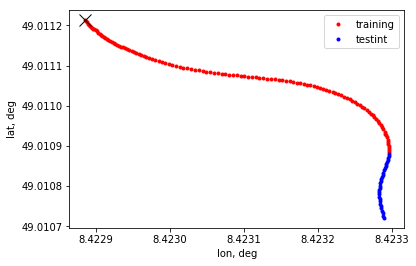

In [9]:
plt.plot(train_lon_points, train_lat_points,"r.", label='training')
plt.plot(test_lon_points, test_lat_points,"b.",label='testint')
plt.plot(lon_points[0], lat_points[0], 'kx', markersize=12)
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")

# 2- IMU Free Positioing

In this section, we use observed acceleration and angular rate of IMU and estimate position, velocity, and orientation

In [10]:
from pyins.integrate import coning_sculling, integrate

/home/sia/tensorflow/venv/py-keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


IMU should be initilized first. In other words, the position, velocity and orientation of platform should be known at the first epoch and IMU estimates the positon, velocity and orientation in the later epcohs. The initilization in testing time is the last point of training data.

In [11]:
#Initialization
test_initial_lat=data.oxts[train_size].packet.lat
test_initial_lon=data.oxts[train_size].packet.lon
test_initial_ve=data.oxts[train_size].packet.ve
test_initial_vn=data.oxts[train_size].packet.vn
test_initial_h=-1* (np.rad2deg(data.oxts[train_size].packet.yaw)) # the heading in KITTI dataset is the negetive of the heading in pyINS. In the dataset, orientation is given in ENU, while in pyINS oreination is calculated in NED.
test_initial_p=data.oxts[train_size].packet.pitch
test_initial_r=data.oxts[train_size].packet.roll

A bit of data manipulation. pykitti provides data in list, while pyins accepts data as numpy.array.

In [12]:
#gyroscopes' observation
test_gyro=np.zeros((test_size-1,3))
test_accel=np.zeros((test_size-1,3))
test_gyro[:,0]=test_wf_points 
test_gyro[:,1]=test_wl_points
test_gyro[:,2]=test_wu_points
# accelerometers' observation
test_accel[:,0]=test_af_points
test_accel[:,1]=test_al_points
test_accel[:,2]=test_au_points 
test_accel[:,2]=test_accel[:,2]-9.8 # gravity reduction

calculating coning and sculling for gyroscope and accelerometer

In [13]:
test_theta, test_dv = coning_sculling(test_gyro * dt, test_accel * dt)

we calculate the position using IMU observations and intial position, velocity and orientation.

In [14]:
test_trajectory = integrate(dt, test_initial_lat, test_initial_lon, test_initial_ve, test_initial_vn , test_initial_h , test_initial_p , test_initial_r ,  test_theta, test_dv, stamp=0)

##### Visualization

Text(0,0.5,'lat, deg')

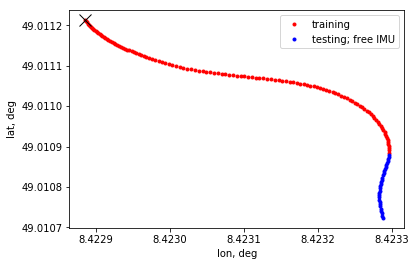

In [15]:
plt.plot(train_lon_points, train_lat_points,"r.", label = 'training' )
plt.plot(test_trajectory.lon, test_trajectory.lat,"b.", label = 'testing; free IMU')
plt.plot(lon_points[0], lat_points[0], 'kx', markersize=12)
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")

Now, we calculate the IMU error

Text(0,0.5,'error, meters')

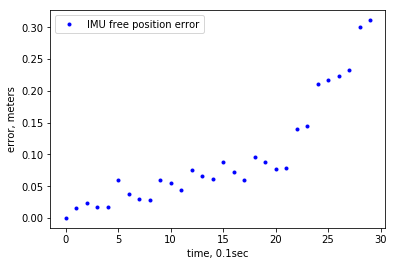

In [16]:
from pyins.coord import lla_to_ecef
re = lla_to_ecef(test_trajectory.lon,test_trajectory.lat)
re_test = lla_to_ecef(test_lon_points,test_lat_points)
free_imu_error = np.linalg.norm(re-re_test,axis=1)
plt.plot(free_imu_error, 'b.',label='IMU free position error')
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("error, meters")

# 3- IMU Calibration using GPS

In this section, we are going to use GPS observations and estiamte IMU biases and scale factors.
First, we should estimate the position, velocity, and orientation using IMU.

In [17]:
#gyroscopes' observation
train_gyro=np.zeros((train_size,3))
train_accel=np.zeros((train_size,3))
train_gyro[:,0]=train_wf_points
train_gyro[:,1]=train_wl_points
train_gyro[:,2]=train_wu_points
# accelerometers' observation
train_accel[:,0]=train_af_points
train_accel[:,1]=train_al_points
train_accel[:,2]=train_au_points
train_accel[:,2]=train_accel[:,2]-9.8
#initialization
train_initial_lat=data.oxts[0].packet.lat
train_initial_lon=data.oxts[0].packet.lon
train_initial_ve=data.oxts[0].packet.ve
train_initial_vn=data.oxts[0].packet.vn
train_initial_y=-1 * (np.rad2deg(data.oxts[0].packet.yaw))
train_initial_p=np.rad2deg(data.oxts[0].packet.pitch)
train_initial_r=np.rad2deg(data.oxts[0].packet.roll)
# coning and sculling
train_theta, train_dv = coning_sculling(train_gyro * dt, train_accel * dt )
# estimating the trajectory using IMU free
train_trajectory = integrate(dt, train_initial_lat, train_initial_lon, train_initial_ve, train_initial_vn , train_initial_y , train_initial_p , train_initial_r ,  train_theta, train_dv, stamp=0)

##### visualization

Text(0,0.5,'lat, deg')

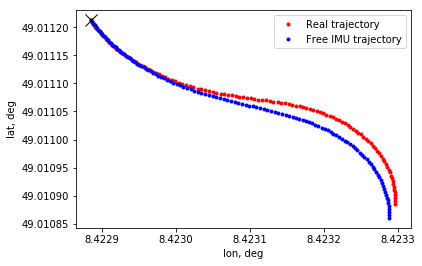

In [18]:
plt.plot(train_lon_points, train_lat_points,"r.", label='Real trajectory')
plt.plot(train_trajectory.lon, train_trajectory.lat,"b.",label='Free IMU trajectory')
plt.plot(train_trajectory.lon[0], train_trajectory.lat[0], 'kx', markersize=12)
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")

Text(0,0.5,'error, meters')

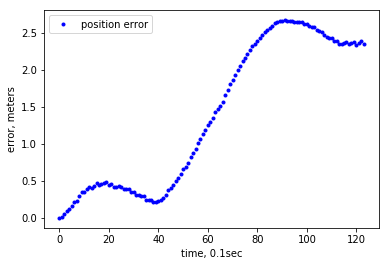

In [19]:
from pyins.coord import lla_to_ecef
re = lla_to_ecef(train_trajectory.lon[0:train_size],train_trajectory.lat[0:train_size])
re_train = lla_to_ecef(train_lon_points,train_lat_points)
#print(re)
#print(re_train)
error = np.linalg.norm(re-re_train,axis=1)
plt.plot(error, 'b.', label='position error')
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("error, meters")

let's check the estimated velocity and heading of free IMU. we compare it with the ground truth. 

Text(0,0.5,'North velocity, m/s')

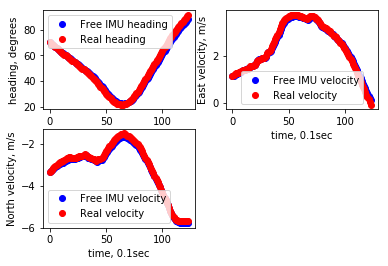

In [20]:
plt.subplot(221)
plt.plot(train_trajectory.h[0:train_size],'bo', label='Free IMU heading')
plt.plot(-1* (np.rad2deg(h_points[0:train_size])),'ro' , label='Real heading')
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("heading, degrees")
plt.subplot(222)
plt.plot(train_trajectory.VE[0:train_size],'bo', label='Free IMU velocity')
plt.plot(ve_points[0:train_size],'ro' , label='Real velocity')
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("East velocity, m/s")
plt.subplot(223)
plt.plot(train_trajectory.VN[0:train_size],'bo', label='Free IMU velocity')
plt.plot(vn_points[0:train_size],'ro' , label='Real velocity')
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("North velocity, m/s")

## Kalman fitler

Let's first create the observation vector 

In [21]:
from pyins.filt import LatLonObs
import pandas as pd
gps_pos_sd = 0.001 #meters
gps_data = pd.DataFrame(index=np.arange(train_size))
gps_data['lat'] = train_lat_points
gps_data['lon'] = train_lon_points
gps_obs = LatLonObs(gps_data, gps_pos_sd)

Let's set the IMU error porperties and create IMU model

In [22]:
gyro_noise =  np.deg2rad(0.2)/ 60 #1e-6  # rad / s^0.5
accel_noise = 0.005/60 #3e-4  # m / s^1.5
gyro_bias_sd =   np.deg2rad(2) / 3600 #np.deg2rad(0.05) / 3600  # 0.05 d/h
accel_bias_sd = 2e-5 #5e-3 #10e-3 #
from pyins.filt import InertialSensor
gyro_model = InertialSensor(bias=gyro_bias_sd, noise=gyro_noise , scale = 0.001,corr_sd = 0.00005, corr_time = 6000)
accel_model = InertialSensor(bias=accel_bias_sd, noise=accel_noise, scale = 0.001,corr_sd = 0.00005, corr_time = 300)
print('noise and bias of gyro:' , gyro_noise , gyro_bias_sd )
print('noise and bias of accelerometer:' ,  accel_noise,accel_bias_sd)

noise and bias of gyro: 5.817764173314432e-05 9.69627362219072e-06
noise and bias of accelerometer: 8.333333333333333e-05 2e-05


Let's run Kalman filter to integrate the GPS and IMU information

In [23]:
from pyins.filt import FeedforwardFilter
ff_filt = FeedforwardFilter(dt, train_trajectory,
                            pos_sd=0.1, vel_sd=0.1, azimuth_sd=0.5, level_sd=0.05,
                            gyro_model=gyro_model, accel_model=accel_model,gyro=train_gyro * dt , accel=train_accel * dt)
ff_results = ff_filt.run(observations=[gps_obs])

The Kalman filter has been applied and the results are stored at the filter's results

##### Visualization

The positon of initialization point and ground truth are the same. The algorithm does not change the intialization point.

In [24]:
print(ff_results.traj.lon[0],ff_results.traj.lat[0])
print(train_lon_points[0],train_lat_points[0])

8.4228850417969 49.011212804408
8.4228850417969 49.011212804408


Text(0,0.5,'error, meters')

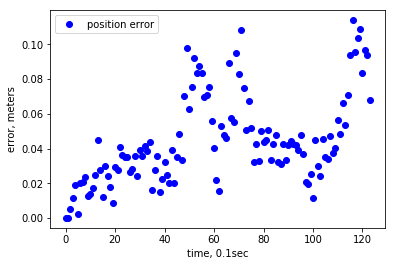

In [25]:
from pyins.coord import lla_to_ecef
re = lla_to_ecef(ff_results.traj.lon,ff_results.traj.lat)
error = np.linalg.norm(re[0:124]-re_train,axis=1)
plt.plot(error,'bo', label='position error')
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("error, meters")

let's visualize the estimate bias of gyroscopes and accelerometers.

gyro_z bias: -4.565560958939423e-05
accel_x bias: -9.768385913044633e-07 accel_y bias: -1.8215272607063738e-05


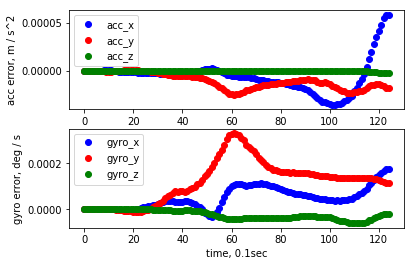

In [26]:
plt.subplot(211)
plt.plot(ff_results.accel_err.BIAS_1,'bo', label='acc_x')
plt.plot(ff_results.accel_err.BIAS_2,'ro', label='acc_y')
plt.plot(ff_results.accel_err.BIAS_3,'go', label='acc_z')
plt.ticklabel_format(useOffset=True)
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("acc error, m / s^2")
plt.subplot(212)
plt.plot(ff_results.gyro_err.BIAS_1,'bo',label='gyro_x')
plt.plot(ff_results.gyro_err.BIAS_2,'ro',label='gyro_y')
plt.plot(ff_results.gyro_err.BIAS_3,'go',label='gyro_z')
plt.ticklabel_format(useOffset=True)
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("gyro error, deg / s")
print('gyro_z bias:',np.mean(ff_results.gyro_err.BIAS_3[100:]))
print('accel_x bias:',np.mean(ff_results.accel_err.BIAS_1[100:]) , 'accel_y bias:' , np.mean(ff_results.accel_err.BIAS_2[100:]))

# Testing Calibrated IMU

In [27]:
#gyroscopes' observation
corrected_gyro=np.zeros((test_size-1,3))
corrected_accel=np.zeros((test_size-1,3))
corrected_gyro[:,0]=test_wf_points-np.mean(ff_results.gyro_err.BIAS_1[100:])
corrected_gyro[:,1]=test_wl_points-np.mean(ff_results.gyro_err.BIAS_2[100:])
corrected_gyro[:,2]=test_wu_points-np.mean(ff_results.gyro_err.BIAS_3[100:])
# accelerometers' observation
corrected_accel[:,0]=test_af_points-np.mean(ff_results.accel_err.BIAS_1[100:])
corrected_accel[:,1]=test_al_points-np.mean(ff_results.accel_err.BIAS_2[100:])
corrected_accel[:,2]=test_au_points-np.mean(ff_results.accel_err.BIAS_3[100:])
corrected_accel[:,2]=corrected_accel[:,2]-9.8 # gravity reduction

In [28]:
corrected_theta, corrected_dv = coning_sculling(corrected_gyro * dt, corrected_accel * dt)
corrected_trajectory = integrate(dt, test_initial_lat, test_initial_lon, test_initial_ve, test_initial_vn , test_initial_h , test_initial_p , test_initial_r ,  corrected_theta, corrected_dv, stamp=0)

Text(0,0.5,'position error, meters')

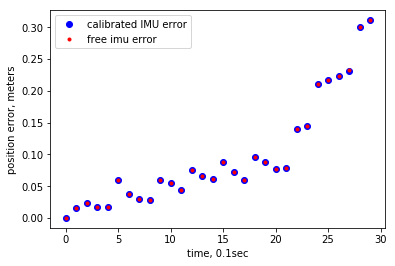

In [29]:
from pyins.coord import lla_to_ecef
re = lla_to_ecef(corrected_trajectory.lon,corrected_trajectory.lat)
re_test = lla_to_ecef(test_lon_points,test_lat_points)
calibrated_IMU_error = np.linalg.norm(re-re_test,axis=1)
plt.plot(calibrated_IMU_error, 'bo',label='calibrated IMU error')
plt.plot(free_imu_error , 'r.',label='free imu error')
plt.legend()
plt.xlabel("time, 0.1sec")
plt.ylabel("position error, meters")

Although the resutls of corrected IMU (blue dots) are better than the results of free IMU (red dots), the kalman filter could not accurately estimate the gyro and accelerometers biases. This is the result of short training time. 

# 4- IMU error modeling using deep learning

### Train the network

In [30]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	return scaler, train_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

we are going to model the IMU error in the training stage. First we estimate the positon error of free IMU.

In [31]:
training_dlon = train_lon_points-train_trajectory.lon[:len(train_lon_points)];
training_dlat = train_lat_points-train_trajectory.lat[:len(train_lat_points)];

testing_dlon = test_lon_points - test_trajectory.lon[:len(test_lon_points)];
testing_dlat = test_lat_points - test_trajectory.lat[:len(test_lat_points)];

we normalize our position using mean and standard deviation

In [32]:
m_lon = np.mean(training_dlon)
m_lat = np.mean(training_dlat)
std_lon = np.std(training_dlon)
std_lat = np.std(training_dlat)
norm_training_dlon=(training_dlon-m_lon)/std_lon
norm_training_dlat=(training_dlat-m_lat)/std_lat

norm_testing_dlon=(testing_dlon-m_lon)/std_lon
norm_testing_dlat=(testing_dlat-m_lat)/std_lat

The data is converted to a supervised learning problem where x is the training input of the series up to epoch t and y is the training output of the series including epoch t 

In [33]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat
lag = 1
# transform data to be supervised learning
supervised_lon = timeseries_to_supervised(norm_training_dlon, lag)
supervised_values_lon = supervised_lon.values
#####
supervised_lat = timeseries_to_supervised(norm_training_dlat, lag)
supervised_values_lat = supervised_lat.values

# transform data to be supervised learning
supervised_test_lon = timeseries_to_supervised(norm_training_dlon, lag)
supervised_values_test_lon = supervised_test_lon.values

x_lon_train = supervised_values_lon[:,0]
y_lon_train = supervised_values_lon[:,1]

x_lat_train = supervised_values_lat[:,0]
y_lat_train = supervised_values_lat[:,1]

x_lon_train = np.reshape(x_lon_train, (1, len(x_lon_train), 1))
y_lon_train = np.reshape(y_lon_train, (1, len(y_lon_train), 1))

x_lat_train = np.reshape(x_lat_train, (1, len(x_lat_train), 1))
y_lat_train = np.reshape(y_lat_train, (1, len(y_lat_train), 1))


x_lon_test = supervised_values_test_lon[:,0]
y_lon_test = supervised_values_test_lon[:,1]
x_lon_test = np.reshape(x_lon_test, (1, len(x_lon_test), 1))
y_lon_test = np.reshape(y_lon_test, (1, len(y_lon_test), 1))

Now, we define our network and train it.

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import LambdaCallback
## num_units = 4
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
#batch_size = 1 -- we only have one sequence, and we used batch_input_shape = (1, None, 1)
batch_size = 1
num_units = 40
num_epochs = 10000
dropout=0.2
# Initialize the RNN
regressor = Sequential()
#regressor.reset_states()
#Use only batch_input_shape
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = num_units, activation = activation_function,  
                   stateful=True,return_sequences=True, recurrent_dropout=dropout,batch_input_shape=(batch_size, None, 1)))
regressor.add(LSTM(units = num_units, activation = activation_function,  
                   stateful=True,return_sequences=True,recurrent_dropout=dropout))
regressor.add(LSTM(units = num_units, activation = activation_function,  
                   stateful=True,return_sequences=True,recurrent_dropout=dropout))
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = optimizer, loss = loss_function)

#important - we need to reset states because we're using a stateful=True model
resetCallback = LambdaCallback(on_epoch_begin=lambda epoch,logs: regressor.reset_states())

# Using the training set to train the model
print(x_lon_train.shape, y_lon_train.shape)
history = regressor.fit(x_lon_train, y_lon_train,batch_size=batch_size, validation_data=(x_lon_test , y_lon_test) , epochs = num_epochs, callbacks=[resetCallback],verbose=1)
#regressor.save('model.h5')

(1, 124, 1) (1, 124, 1)
Train on 1 samples, validate on 1 samples
Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: 1.1201 - val_loss: 1.0748
Epoch 2/10000
1/1 [==============================] - 0s 377ms/step - loss: 1.0660 - val_loss: 1.0415
Epoch 3/10000
1/1 [==============================] - 0s 372ms/step - loss: 1.0509 - val_loss: 1.0168
Epoch 4/10000
1/1 [==============================] - 0s 385ms/step - loss: 1.0132 - val_loss: 1.0031
Epoch 5/10000
1/1 [==============================] - 0s 391ms/step - loss: 0.9991 - val_loss: 0.9987
Epoch 6/10000
1/1 [==============================] - 0s 399ms/step - loss: 0.9857 - val_loss: 1.0033
Epoch 7/10000
1/1 [==============================] - 0s 409ms/step - loss: 0.9859 - val_loss: 1.0147
Epoch 8/10000
1/1 [==============================] - 0s 452ms/step - loss: 0.9887 - val_loss: 1.0278
Epoch 9/10000
1/1 [==============================] - 0s 431ms/step - loss: 1.0114 - val_loss: 1.0357
Epoch 10/10000
1/1 [========

Epoch 81/10000
1/1 [==============================] - 0s 390ms/step - loss: 0.3451 - val_loss: 1.0767
Epoch 82/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.3304 - val_loss: 1.0929
Epoch 83/10000
1/1 [==============================] - 0s 403ms/step - loss: 0.3272 - val_loss: 1.2042
Epoch 84/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.2600 - val_loss: 1.1678
Epoch 85/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.3159 - val_loss: 1.1123
Epoch 86/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.2436 - val_loss: 1.3682
Epoch 87/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.2104 - val_loss: 1.4987
Epoch 88/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.2078 - val_loss: 1.5503
Epoch 89/10000
1/1 [==============================] - 0s 403ms/step - loss: 0.2558 - val_loss: 1.4250
Epoch 90/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.1475

Epoch 161/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0778 - val_loss: 1.1434
Epoch 162/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0627 - val_loss: 1.2369
Epoch 163/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0781 - val_loss: 1.2971
Epoch 164/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0418 - val_loss: 1.1986
Epoch 165/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0404 - val_loss: 1.3081
Epoch 166/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0351 - val_loss: 1.3110
Epoch 167/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0693 - val_loss: 1.3091
Epoch 168/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0319 - val_loss: 1.2328
Epoch 169/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0343 - val_loss: 1.2216
Epoch 170/10000
1/1 [==============================] - 0s 449ms/step - lo

Epoch 241/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0381 - val_loss: 1.2053
Epoch 242/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0615 - val_loss: 1.2221
Epoch 243/10000
1/1 [==============================] - 0s 453ms/step - loss: 0.0379 - val_loss: 1.1524
Epoch 244/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0831 - val_loss: 1.0360
Epoch 245/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0274 - val_loss: 0.9745
Epoch 246/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0563 - val_loss: 0.8965
Epoch 247/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0267 - val_loss: 0.8761
Epoch 248/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.1961 - val_loss: 0.8583
Epoch 249/10000
1/1 [==============================] - 0s 380ms/step - loss: 0.0343 - val_loss: 0.9529
Epoch 250/10000
1/1 [==============================] - 0s 398ms/step - lo

Epoch 321/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0311 - val_loss: 1.2428
Epoch 322/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0577 - val_loss: 1.2611
Epoch 323/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0724 - val_loss: 1.1785
Epoch 324/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0295 - val_loss: 1.1517
Epoch 325/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0298 - val_loss: 1.0710
Epoch 326/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0297 - val_loss: 0.9379
Epoch 327/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0267 - val_loss: 0.9676
Epoch 328/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0960 - val_loss: 0.9618
Epoch 329/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0987 - val_loss: 0.8282
Epoch 330/10000
1/1 [==============================] - 0s 412ms/step - lo

Epoch 401/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.2197 - val_loss: 0.7858
Epoch 402/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0329 - val_loss: 0.9245
Epoch 403/10000
1/1 [==============================] - 0s 397ms/step - loss: 0.0348 - val_loss: 1.0062
Epoch 404/10000
1/1 [==============================] - 0s 399ms/step - loss: 0.0571 - val_loss: 1.1703
Epoch 405/10000
1/1 [==============================] - 0s 399ms/step - loss: 0.0326 - val_loss: 1.0083
Epoch 406/10000
1/1 [==============================] - 0s 402ms/step - loss: 0.0420 - val_loss: 1.2194
Epoch 407/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0424 - val_loss: 1.1883
Epoch 408/10000
1/1 [==============================] - 0s 397ms/step - loss: 0.0409 - val_loss: 1.1365
Epoch 409/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0958 - val_loss: 1.1816
Epoch 410/10000
1/1 [==============================] - 0s 418ms/step - lo

Epoch 481/10000
1/1 [==============================] - 0s 394ms/step - loss: 0.0480 - val_loss: 1.0101
Epoch 482/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0264 - val_loss: 0.9168
Epoch 483/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0444 - val_loss: 0.9035
Epoch 484/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0670 - val_loss: 0.6990
Epoch 485/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0278 - val_loss: 0.8261
Epoch 486/10000
1/1 [==============================] - 0s 451ms/step - loss: 0.0316 - val_loss: 0.7776
Epoch 487/10000
1/1 [==============================] - 0s 440ms/step - loss: 0.0345 - val_loss: 0.8709
Epoch 488/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.1018 - val_loss: 0.8315
Epoch 489/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0262 - val_loss: 0.9345
Epoch 490/10000
1/1 [==============================] - 0s 424ms/step - lo

Epoch 561/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0649 - val_loss: 0.8077
Epoch 562/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0376 - val_loss: 0.8884
Epoch 563/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0381 - val_loss: 1.0592
Epoch 564/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0854 - val_loss: 1.1183
Epoch 565/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0514 - val_loss: 1.1139
Epoch 566/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0413 - val_loss: 1.1288
Epoch 567/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0389 - val_loss: 1.0441
Epoch 568/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0254 - val_loss: 0.9945
Epoch 569/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0555 - val_loss: 0.9477
Epoch 570/10000
1/1 [==============================] - 0s 434ms/step - lo

Epoch 641/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0253 - val_loss: 0.7526
Epoch 642/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0222 - val_loss: 0.7940
Epoch 643/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0458 - val_loss: 0.7916
Epoch 644/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0243 - val_loss: 0.8394
Epoch 645/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0216 - val_loss: 0.7766
Epoch 646/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0232 - val_loss: 0.7755
Epoch 647/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0205 - val_loss: 0.7179
Epoch 648/10000
1/1 [==============================] - 0s 400ms/step - loss: 0.0264 - val_loss: 0.7376
Epoch 649/10000
1/1 [==============================] - 0s 398ms/step - loss: 0.0236 - val_loss: 0.7661
Epoch 650/10000
1/1 [==============================] - 0s 416ms/step - lo

Epoch 721/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0240 - val_loss: 0.6666
Epoch 722/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0287 - val_loss: 0.7008
Epoch 723/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0191 - val_loss: 0.6732
Epoch 724/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0177 - val_loss: 0.6081
Epoch 725/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0172 - val_loss: 0.6551
Epoch 726/10000
1/1 [==============================] - 0s 445ms/step - loss: 0.0198 - val_loss: 0.6652
Epoch 727/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0244 - val_loss: 0.5553
Epoch 728/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0380 - val_loss: 0.6601
Epoch 729/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0396 - val_loss: 0.6477
Epoch 730/10000
1/1 [==============================] - 0s 420ms/step - lo

Epoch 801/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0532 - val_loss: 0.6642
Epoch 802/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0170 - val_loss: 0.6243
Epoch 803/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0370 - val_loss: 0.5499
Epoch 804/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0425 - val_loss: 0.5549
Epoch 805/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0232 - val_loss: 0.6475
Epoch 806/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0220 - val_loss: 0.6515
Epoch 807/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0301 - val_loss: 0.5875
Epoch 808/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0283 - val_loss: 0.7141
Epoch 809/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0215 - val_loss: 0.6812
Epoch 810/10000
1/1 [==============================] - 0s 418ms/step - lo

Epoch 881/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0284 - val_loss: 0.7211
Epoch 882/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0210 - val_loss: 0.7107
Epoch 883/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0239 - val_loss: 0.7293
Epoch 884/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0250 - val_loss: 0.7297
Epoch 885/10000
1/1 [==============================] - 0s 402ms/step - loss: 0.0321 - val_loss: 0.7167
Epoch 886/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0157 - val_loss: 0.7054
Epoch 887/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0242 - val_loss: 0.7197
Epoch 888/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0171 - val_loss: 0.7260
Epoch 889/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0302 - val_loss: 0.6675
Epoch 890/10000
1/1 [==============================] - 0s 429ms/step - lo

Epoch 961/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0250 - val_loss: 0.5800
Epoch 962/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0331 - val_loss: 0.5860
Epoch 963/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0173 - val_loss: 0.6284
Epoch 964/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0181 - val_loss: 0.5822
Epoch 965/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0351 - val_loss: 0.6454
Epoch 966/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0497 - val_loss: 0.7195
Epoch 967/10000
1/1 [==============================] - 0s 446ms/step - loss: 0.0178 - val_loss: 0.6906
Epoch 968/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0157 - val_loss: 0.6870
Epoch 969/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0255 - val_loss: 0.6688
Epoch 970/10000
1/1 [==============================] - 0s 433ms/step - lo

1/1 [==============================] - 0s 415ms/step - loss: 0.0240 - val_loss: 0.5189
Epoch 1041/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0136 - val_loss: 0.6137
Epoch 1042/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0187 - val_loss: 0.5872
Epoch 1043/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0221 - val_loss: 0.5784
Epoch 1044/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0166 - val_loss: 0.5516
Epoch 1045/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0172 - val_loss: 0.5032
Epoch 1046/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0153 - val_loss: 0.5428
Epoch 1047/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0217 - val_loss: 0.5123
Epoch 1048/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0165 - val_loss: 0.5433
Epoch 1049/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0

Epoch 1119/10000
1/1 [==============================] - 0s 444ms/step - loss: 0.0179 - val_loss: 0.5395
Epoch 1120/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0154 - val_loss: 0.5176
Epoch 1121/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0561 - val_loss: 0.4370
Epoch 1122/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0166 - val_loss: 0.5160
Epoch 1123/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0352 - val_loss: 0.5228
Epoch 1124/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0143 - val_loss: 0.5575
Epoch 1125/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0165 - val_loss: 0.6151
Epoch 1126/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0253 - val_loss: 0.6122
Epoch 1127/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0128 - val_loss: 0.6248
Epoch 1128/10000
1/1 [==============================] - 0s 416ms

Epoch 1198/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0280 - val_loss: 0.4623
Epoch 1199/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0393 - val_loss: 0.4433
Epoch 1200/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0178 - val_loss: 0.4930
Epoch 1201/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0208 - val_loss: 0.5227
Epoch 1202/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0164 - val_loss: 0.5737
Epoch 1203/10000
1/1 [==============================] - 0s 410ms/step - loss: 0.0136 - val_loss: 0.5502
Epoch 1204/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0347 - val_loss: 0.5119
Epoch 1205/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0207 - val_loss: 0.5814
Epoch 1206/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0179 - val_loss: 0.5386
Epoch 1207/10000
1/1 [==============================] - 0s 413ms

Epoch 1277/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0115 - val_loss: 0.4952
Epoch 1278/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0135 - val_loss: 0.4543
Epoch 1279/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0117 - val_loss: 0.4712
Epoch 1280/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0119 - val_loss: 0.4611
Epoch 1281/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0137 - val_loss: 0.4292
Epoch 1282/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0390 - val_loss: 0.4432
Epoch 1283/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0139 - val_loss: 0.4616
Epoch 1284/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0183 - val_loss: 0.4817
Epoch 1285/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0141 - val_loss: 0.4925
Epoch 1286/10000
1/1 [==============================] - 0s 436ms

Epoch 1356/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0127 - val_loss: 0.5095
Epoch 1357/10000
1/1 [==============================] - 0s 450ms/step - loss: 0.0134 - val_loss: 0.4471
Epoch 1358/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0299 - val_loss: 0.4663
Epoch 1359/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0234 - val_loss: 0.4942
Epoch 1360/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0134 - val_loss: 0.5257
Epoch 1361/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0264 - val_loss: 0.4771
Epoch 1362/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0250 - val_loss: 0.4576
Epoch 1363/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0133 - val_loss: 0.4221
Epoch 1364/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0124 - val_loss: 0.4184
Epoch 1365/10000
1/1 [==============================] - 0s 421ms

Epoch 1435/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0260 - val_loss: 0.3968
Epoch 1436/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0123 - val_loss: 0.4355
Epoch 1437/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0146 - val_loss: 0.4650
Epoch 1438/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0144 - val_loss: 0.4342
Epoch 1439/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0139 - val_loss: 0.4378
Epoch 1440/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0171 - val_loss: 0.4624
Epoch 1441/10000
1/1 [==============================] - 0s 404ms/step - loss: 0.0207 - val_loss: 0.4283
Epoch 1442/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0262 - val_loss: 0.4762
Epoch 1443/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0121 - val_loss: 0.4371
Epoch 1444/10000
1/1 [==============================] - 0s 427ms

Epoch 1514/10000
1/1 [==============================] - 0s 398ms/step - loss: 0.0177 - val_loss: 0.3399
Epoch 1515/10000
1/1 [==============================] - 0s 390ms/step - loss: 0.0107 - val_loss: 0.3499
Epoch 1516/10000
1/1 [==============================] - 0s 397ms/step - loss: 0.0192 - val_loss: 0.3368
Epoch 1517/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0138 - val_loss: 0.3976
Epoch 1518/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0298 - val_loss: 0.3936
Epoch 1519/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0135 - val_loss: 0.4098
Epoch 1520/10000
1/1 [==============================] - 0s 440ms/step - loss: 0.0101 - val_loss: 0.4424
Epoch 1521/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0138 - val_loss: 0.4480
Epoch 1522/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0164 - val_loss: 0.4653
Epoch 1523/10000
1/1 [==============================] - 0s 420ms

Epoch 1593/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0109 - val_loss: 0.3764
Epoch 1594/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0137 - val_loss: 0.3438
Epoch 1595/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0112 - val_loss: 0.3890
Epoch 1596/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0246 - val_loss: 0.3700
Epoch 1597/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0131 - val_loss: 0.3583
Epoch 1598/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0133 - val_loss: 0.3486
Epoch 1599/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0124 - val_loss: 0.4080
Epoch 1600/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0156 - val_loss: 0.4099
Epoch 1601/10000
1/1 [==============================] - 0s 400ms/step - loss: 0.0220 - val_loss: 0.4264
Epoch 1602/10000
1/1 [==============================] - 0s 414ms

Epoch 1672/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0140 - val_loss: 0.3101
Epoch 1673/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0124 - val_loss: 0.2866
Epoch 1674/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0689 - val_loss: 0.2784
Epoch 1675/10000
1/1 [==============================] - 0s 444ms/step - loss: 0.0706 - val_loss: 0.3288
Epoch 1676/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0179 - val_loss: 0.3864
Epoch 1677/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0117 - val_loss: 0.4646
Epoch 1678/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0114 - val_loss: 0.5002
Epoch 1679/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0789 - val_loss: 0.5304
Epoch 1680/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0443 - val_loss: 0.4841
Epoch 1681/10000
1/1 [==============================] - 0s 442ms

Epoch 1751/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0202 - val_loss: 0.3349
Epoch 1752/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0097 - val_loss: 0.3646
Epoch 1753/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0103 - val_loss: 0.3900
Epoch 1754/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0124 - val_loss: 0.3485
Epoch 1755/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0099 - val_loss: 0.3789
Epoch 1756/10000
1/1 [==============================] - 0s 406ms/step - loss: 0.0401 - val_loss: 0.3989
Epoch 1757/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0099 - val_loss: 0.3748
Epoch 1758/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0114 - val_loss: 0.3582
Epoch 1759/10000
1/1 [==============================] - 0s 402ms/step - loss: 0.0107 - val_loss: 0.3430
Epoch 1760/10000
1/1 [==============================] - 0s 416ms

Epoch 1830/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0102 - val_loss: 0.3305
Epoch 1831/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0105 - val_loss: 0.3232
Epoch 1832/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0117 - val_loss: 0.2893
Epoch 1833/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0097 - val_loss: 0.3343
Epoch 1834/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0105 - val_loss: 0.3283
Epoch 1835/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0186 - val_loss: 0.3490
Epoch 1836/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0134 - val_loss: 0.3250
Epoch 1837/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0115 - val_loss: 0.3483
Epoch 1838/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0104 - val_loss: 0.3024
Epoch 1839/10000
1/1 [==============================] - 0s 425ms

Epoch 1909/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0109 - val_loss: 0.3164
Epoch 1910/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0105 - val_loss: 0.3595
Epoch 1911/10000
1/1 [==============================] - 0s 464ms/step - loss: 0.0110 - val_loss: 0.3697
Epoch 1912/10000
1/1 [==============================] - 0s 458ms/step - loss: 0.0116 - val_loss: 0.3891
Epoch 1913/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0100 - val_loss: 0.3874
Epoch 1914/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0206 - val_loss: 0.3975
Epoch 1915/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0183 - val_loss: 0.3632
Epoch 1916/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0234 - val_loss: 0.3312
Epoch 1917/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0114 - val_loss: 0.3113
Epoch 1918/10000
1/1 [==============================] - 0s 415ms

Epoch 1988/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0090 - val_loss: 0.2744
Epoch 1989/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0124 - val_loss: 0.2730
Epoch 1990/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0132 - val_loss: 0.2566
Epoch 1991/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0130 - val_loss: 0.2592
Epoch 1992/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0098 - val_loss: 0.2778
Epoch 1993/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0093 - val_loss: 0.2918
Epoch 1994/10000
1/1 [==============================] - 0s 446ms/step - loss: 0.0089 - val_loss: 0.2844
Epoch 1995/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0096 - val_loss: 0.2903
Epoch 1996/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0199 - val_loss: 0.2545
Epoch 1997/10000
1/1 [==============================] - 0s 419ms

Epoch 2067/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0119 - val_loss: 0.3160
Epoch 2068/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0101 - val_loss: 0.3039
Epoch 2069/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0089 - val_loss: 0.2835
Epoch 2070/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0100 - val_loss: 0.3025
Epoch 2071/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0105 - val_loss: 0.2807
Epoch 2072/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0088 - val_loss: 0.2510
Epoch 2073/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0093 - val_loss: 0.2621
Epoch 2074/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0083 - val_loss: 0.2436
Epoch 2075/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0100 - val_loss: 0.2265
Epoch 2076/10000
1/1 [==============================] - 0s 415ms

Epoch 2146/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0082 - val_loss: 0.2343
Epoch 2147/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0140 - val_loss: 0.2240
Epoch 2148/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0149 - val_loss: 0.2459
Epoch 2149/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0163 - val_loss: 0.2421
Epoch 2150/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0194 - val_loss: 0.2982
Epoch 2151/10000
1/1 [==============================] - 0s 448ms/step - loss: 0.0082 - val_loss: 0.3216
Epoch 2152/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0119 - val_loss: 0.3190
Epoch 2153/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0163 - val_loss: 0.3447
Epoch 2154/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0159 - val_loss: 0.3380
Epoch 2155/10000
1/1 [==============================] - 0s 422ms

Epoch 2225/10000
1/1 [==============================] - 0s 410ms/step - loss: 0.0121 - val_loss: 0.2819
Epoch 2226/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0081 - val_loss: 0.2913
Epoch 2227/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0116 - val_loss: 0.2868
Epoch 2228/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0083 - val_loss: 0.2867
Epoch 2229/10000
1/1 [==============================] - 0s 445ms/step - loss: 0.0097 - val_loss: 0.2883
Epoch 2230/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0115 - val_loss: 0.2613
Epoch 2231/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0083 - val_loss: 0.2681
Epoch 2232/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0081 - val_loss: 0.2606
Epoch 2233/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0080 - val_loss: 0.2491
Epoch 2234/10000
1/1 [==============================] - 0s 426ms

Epoch 2304/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0118 - val_loss: 0.2569
Epoch 2305/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0153 - val_loss: 0.2441
Epoch 2306/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0109 - val_loss: 0.2405
Epoch 2307/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0093 - val_loss: 0.2171
Epoch 2308/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0212 - val_loss: 0.2031
Epoch 2309/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0151 - val_loss: 0.2385
Epoch 2310/10000
1/1 [==============================] - 0s 410ms/step - loss: 0.0106 - val_loss: 0.2440
Epoch 2311/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0075 - val_loss: 0.2535
Epoch 2312/10000
1/1 [==============================] - 0s 450ms/step - loss: 0.0082 - val_loss: 0.2559
Epoch 2313/10000
1/1 [==============================] - 0s 403ms

Epoch 2383/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0230 - val_loss: 0.1959
Epoch 2384/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0076 - val_loss: 0.2122
Epoch 2385/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0091 - val_loss: 0.2393
Epoch 2386/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0103 - val_loss: 0.2455
Epoch 2387/10000
1/1 [==============================] - 0s 401ms/step - loss: 0.0103 - val_loss: 0.2639
Epoch 2388/10000
1/1 [==============================] - 0s 398ms/step - loss: 0.0075 - val_loss: 0.2404
Epoch 2389/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0074 - val_loss: 0.2443
Epoch 2390/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0107 - val_loss: 0.2587
Epoch 2391/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0094 - val_loss: 0.2410
Epoch 2392/10000
1/1 [==============================] - 0s 424ms

Epoch 2462/10000
1/1 [==============================] - 0s 446ms/step - loss: 0.0081 - val_loss: 0.2299
Epoch 2463/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0088 - val_loss: 0.2346
Epoch 2464/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0088 - val_loss: 0.2317
Epoch 2465/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0082 - val_loss: 0.2313
Epoch 2466/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0119 - val_loss: 0.2227
Epoch 2467/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0068 - val_loss: 0.2321
Epoch 2468/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0120 - val_loss: 0.2193
Epoch 2469/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0074 - val_loss: 0.2413
Epoch 2470/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0104 - val_loss: 0.2119
Epoch 2471/10000
1/1 [==============================] - 0s 431ms

Epoch 2541/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0115 - val_loss: 0.2650
Epoch 2542/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0070 - val_loss: 0.2556
Epoch 2543/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0074 - val_loss: 0.2386
Epoch 2544/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0092 - val_loss: 0.2293
Epoch 2545/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0085 - val_loss: 0.2253
Epoch 2546/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0107 - val_loss: 0.2273
Epoch 2547/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0069 - val_loss: 0.2114
Epoch 2548/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0067 - val_loss: 0.2131
Epoch 2549/10000
1/1 [==============================] - 0s 410ms/step - loss: 0.0079 - val_loss: 0.2120
Epoch 2550/10000
1/1 [==============================] - 0s 413ms

Epoch 2620/10000
1/1 [==============================] - 0s 405ms/step - loss: 0.0069 - val_loss: 0.2073
Epoch 2621/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0091 - val_loss: 0.1905
Epoch 2622/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0082 - val_loss: 0.1929
Epoch 2623/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0114 - val_loss: 0.1933
Epoch 2624/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0067 - val_loss: 0.1931
Epoch 2625/10000
1/1 [==============================] - 0s 454ms/step - loss: 0.0079 - val_loss: 0.1930
Epoch 2626/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0073 - val_loss: 0.1786
Epoch 2627/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0070 - val_loss: 0.1909
Epoch 2628/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0066 - val_loss: 0.1881
Epoch 2629/10000
1/1 [==============================] - 0s 438ms

Epoch 2699/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0193 - val_loss: 0.1634
Epoch 2700/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0152 - val_loss: 0.1685
Epoch 2701/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0067 - val_loss: 0.1970
Epoch 2702/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0065 - val_loss: 0.1974
Epoch 2703/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0108 - val_loss: 0.2318
Epoch 2704/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0079 - val_loss: 0.2219
Epoch 2705/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0076 - val_loss: 0.2161
Epoch 2706/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0072 - val_loss: 0.2120
Epoch 2707/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0073 - val_loss: 0.2009
Epoch 2708/10000
1/1 [==============================] - 0s 423ms

Epoch 2778/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0065 - val_loss: 0.1876
Epoch 2779/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0074 - val_loss: 0.1923
Epoch 2780/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0066 - val_loss: 0.1775
Epoch 2781/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0081 - val_loss: 0.1943
Epoch 2782/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0064 - val_loss: 0.1711
Epoch 2783/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0076 - val_loss: 0.1788
Epoch 2784/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0137 - val_loss: 0.1947
Epoch 2785/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0065 - val_loss: 0.1941
Epoch 2786/10000
1/1 [==============================] - 0s 447ms/step - loss: 0.0110 - val_loss: 0.1874
Epoch 2787/10000
1/1 [==============================] - 0s 427ms

Epoch 2857/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0166 - val_loss: 0.1939
Epoch 2858/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0063 - val_loss: 0.1723
Epoch 2859/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0085 - val_loss: 0.1613
Epoch 2860/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0065 - val_loss: 0.1527
Epoch 2861/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0085 - val_loss: 0.1733
Epoch 2862/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0057 - val_loss: 0.1686
Epoch 2863/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0116 - val_loss: 0.1681
Epoch 2864/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0069 - val_loss: 0.1677
Epoch 2865/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0069 - val_loss: 0.1764
Epoch 2866/10000
1/1 [==============================] - 0s 423ms

Epoch 2936/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0059 - val_loss: 0.1536
Epoch 2937/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0067 - val_loss: 0.1540
Epoch 2938/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0063 - val_loss: 0.1538
Epoch 2939/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0059 - val_loss: 0.1536
Epoch 2940/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0082 - val_loss: 0.1465
Epoch 2941/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0075 - val_loss: 0.1472
Epoch 2942/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0062 - val_loss: 0.1595
Epoch 2943/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0074 - val_loss: 0.1497
Epoch 2944/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0062 - val_loss: 0.1564
Epoch 2945/10000
1/1 [==============================] - 0s 413ms

Epoch 3015/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0060 - val_loss: 0.1485
Epoch 3016/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0058 - val_loss: 0.1486
Epoch 3017/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0077 - val_loss: 0.1391
Epoch 3018/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0074 - val_loss: 0.1353
Epoch 3019/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0129 - val_loss: 0.1351
Epoch 3020/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0057 - val_loss: 0.1464
Epoch 3021/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0059 - val_loss: 0.1503
Epoch 3022/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0065 - val_loss: 0.1568
Epoch 3023/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0079 - val_loss: 0.1519
Epoch 3024/10000
1/1 [==============================] - 0s 423ms

Epoch 3094/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0062 - val_loss: 0.1448
Epoch 3095/10000
1/1 [==============================] - 0s 406ms/step - loss: 0.0084 - val_loss: 0.1492
Epoch 3096/10000
1/1 [==============================] - 0s 401ms/step - loss: 0.0056 - val_loss: 0.1389
Epoch 3097/10000
1/1 [==============================] - 0s 409ms/step - loss: 0.0092 - val_loss: 0.1429
Epoch 3098/10000
1/1 [==============================] - 0s 384ms/step - loss: 0.0060 - val_loss: 0.1456
Epoch 3099/10000
1/1 [==============================] - 0s 403ms/step - loss: 0.0143 - val_loss: 0.1493
Epoch 3100/10000
1/1 [==============================] - 0s 394ms/step - loss: 0.0056 - val_loss: 0.1509
Epoch 3101/10000
1/1 [==============================] - 0s 388ms/step - loss: 0.0055 - val_loss: 0.1642
Epoch 3102/10000
1/1 [==============================] - 0s 401ms/step - loss: 0.0062 - val_loss: 0.1678
Epoch 3103/10000
1/1 [==============================] - 0s 390ms

Epoch 3173/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0061 - val_loss: 0.1282
Epoch 3174/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0050 - val_loss: 0.1301
Epoch 3175/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0077 - val_loss: 0.1360
Epoch 3176/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0054 - val_loss: 0.1506
Epoch 3177/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0065 - val_loss: 0.1485
Epoch 3178/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0058 - val_loss: 0.1463
Epoch 3179/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0061 - val_loss: 0.1611
Epoch 3180/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0054 - val_loss: 0.1542
Epoch 3181/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0094 - val_loss: 0.1456
Epoch 3182/10000
1/1 [==============================] - 0s 435ms

Epoch 3252/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0047 - val_loss: 0.1286
Epoch 3253/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0051 - val_loss: 0.1326
Epoch 3254/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0049 - val_loss: 0.1410
Epoch 3255/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0048 - val_loss: 0.1350
Epoch 3256/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0055 - val_loss: 0.1409
Epoch 3257/10000
1/1 [==============================] - 0s 440ms/step - loss: 0.0050 - val_loss: 0.1392
Epoch 3258/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0059 - val_loss: 0.1385
Epoch 3259/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0051 - val_loss: 0.1342
Epoch 3260/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0065 - val_loss: 0.1310
Epoch 3261/10000
1/1 [==============================] - 0s 417ms

Epoch 3331/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0051 - val_loss: 0.1080
Epoch 3332/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0046 - val_loss: 0.1034
Epoch 3333/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0068 - val_loss: 0.1008
Epoch 3334/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0045 - val_loss: 0.1039
Epoch 3335/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0061 - val_loss: 0.1015
Epoch 3336/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0065 - val_loss: 0.1080
Epoch 3337/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0056 - val_loss: 0.1147
Epoch 3338/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0056 - val_loss: 0.1185
Epoch 3339/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0055 - val_loss: 0.1299
Epoch 3340/10000
1/1 [==============================] - 0s 442ms

Epoch 3410/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0047 - val_loss: 0.1340
Epoch 3411/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0124 - val_loss: 0.1297
Epoch 3412/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0075 - val_loss: 0.1075
Epoch 3413/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0049 - val_loss: 0.1013
Epoch 3414/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0082 - val_loss: 0.0974
Epoch 3415/10000
1/1 [==============================] - 0s 446ms/step - loss: 0.0053 - val_loss: 0.0923
Epoch 3416/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0085 - val_loss: 0.0935
Epoch 3417/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0054 - val_loss: 0.0985
Epoch 3418/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0057 - val_loss: 0.0994
Epoch 3419/10000
1/1 [==============================] - 0s 425ms

Epoch 3489/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0065 - val_loss: 0.1048
Epoch 3490/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0043 - val_loss: 0.0967
Epoch 3491/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0041 - val_loss: 0.0879
Epoch 3492/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0054 - val_loss: 0.0924
Epoch 3493/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0062 - val_loss: 0.0922
Epoch 3494/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0052 - val_loss: 0.0992
Epoch 3495/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0053 - val_loss: 0.1019
Epoch 3496/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0059 - val_loss: 0.1016
Epoch 3497/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0053 - val_loss: 0.1041
Epoch 3498/10000
1/1 [==============================] - 0s 404ms

Epoch 3568/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0041 - val_loss: 0.1155
Epoch 3569/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0098 - val_loss: 0.1113
Epoch 3570/10000
1/1 [==============================] - 0s 403ms/step - loss: 0.0093 - val_loss: 0.1066
Epoch 3571/10000
1/1 [==============================] - 0s 400ms/step - loss: 0.0052 - val_loss: 0.1001
Epoch 3572/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0040 - val_loss: 0.0968
Epoch 3573/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0042 - val_loss: 0.0940
Epoch 3574/10000
1/1 [==============================] - 0s 410ms/step - loss: 0.0049 - val_loss: 0.0884
Epoch 3575/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0084 - val_loss: 0.0891
Epoch 3576/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0043 - val_loss: 0.0966
Epoch 3577/10000
1/1 [==============================] - 0s 407ms

Epoch 3647/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0048 - val_loss: 0.0846
Epoch 3648/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0051 - val_loss: 0.0867
Epoch 3649/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0035 - val_loss: 0.0891
Epoch 3650/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0051 - val_loss: 0.0982
Epoch 3651/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0040 - val_loss: 0.0962
Epoch 3652/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0039 - val_loss: 0.0982
Epoch 3653/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0039 - val_loss: 0.0926
Epoch 3654/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0052 - val_loss: 0.0948
Epoch 3655/10000
1/1 [==============================] - 0s 399ms/step - loss: 0.0044 - val_loss: 0.0815
Epoch 3656/10000
1/1 [==============================] - 0s 406ms

Epoch 3726/10000
1/1 [==============================] - 0s 444ms/step - loss: 0.0036 - val_loss: 0.0842
Epoch 3727/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0037 - val_loss: 0.0792
Epoch 3728/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0036 - val_loss: 0.0808
Epoch 3729/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0046 - val_loss: 0.0807
Epoch 3730/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0038 - val_loss: 0.0818
Epoch 3731/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0064 - val_loss: 0.0859
Epoch 3732/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0036 - val_loss: 0.0845
Epoch 3733/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0039 - val_loss: 0.0900
Epoch 3734/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0050 - val_loss: 0.0910
Epoch 3735/10000
1/1 [==============================] - 0s 423ms

Epoch 3805/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0050 - val_loss: 0.1055
Epoch 3806/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0110 - val_loss: 0.1001
Epoch 3807/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0087 - val_loss: 0.0822
Epoch 3808/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0036 - val_loss: 0.0701
Epoch 3809/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0045 - val_loss: 0.0588
Epoch 3810/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0078 - val_loss: 0.0590
Epoch 3811/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0058 - val_loss: 0.0629
Epoch 3812/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0057 - val_loss: 0.0650
Epoch 3813/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0036 - val_loss: 0.0728
Epoch 3814/10000
1/1 [==============================] - 0s 427ms

Epoch 3884/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0031 - val_loss: 0.0669
Epoch 3885/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0038 - val_loss: 0.0766
Epoch 3886/10000
1/1 [==============================] - 0s 454ms/step - loss: 0.0035 - val_loss: 0.0717
Epoch 3887/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0046 - val_loss: 0.0752
Epoch 3888/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0045 - val_loss: 0.0671
Epoch 3889/10000
1/1 [==============================] - 0s 451ms/step - loss: 0.0037 - val_loss: 0.0627
Epoch 3890/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0031 - val_loss: 0.0622
Epoch 3891/10000
1/1 [==============================] - 0s 395ms/step - loss: 0.0034 - val_loss: 0.0591
Epoch 3892/10000
1/1 [==============================] - 0s 409ms/step - loss: 0.0054 - val_loss: 0.0617
Epoch 3893/10000
1/1 [==============================] - 0s 445ms

Epoch 3963/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0029 - val_loss: 0.0637
Epoch 3964/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0028 - val_loss: 0.0597
Epoch 3965/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0029 - val_loss: 0.0578
Epoch 3966/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0064 - val_loss: 0.0589
Epoch 3967/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0047 - val_loss: 0.0634
Epoch 3968/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0076 - val_loss: 0.0737
Epoch 3969/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0097 - val_loss: 0.0906
Epoch 3970/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0061 - val_loss: 0.0879
Epoch 3971/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0112 - val_loss: 0.0814
Epoch 3972/10000
1/1 [==============================] - 0s 432ms

Epoch 4042/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0031 - val_loss: 0.0774
Epoch 4043/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0051 - val_loss: 0.0785
Epoch 4044/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0080 - val_loss: 0.0660
Epoch 4045/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0026 - val_loss: 0.0584
Epoch 4046/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0039 - val_loss: 0.0505
Epoch 4047/10000
1/1 [==============================] - 0s 453ms/step - loss: 0.0036 - val_loss: 0.0503
Epoch 4048/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0050 - val_loss: 0.0556
Epoch 4049/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0035 - val_loss: 0.0571
Epoch 4050/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0053 - val_loss: 0.0564
Epoch 4051/10000
1/1 [==============================] - 0s 446ms

Epoch 4121/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0034 - val_loss: 0.0613
Epoch 4122/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0028 - val_loss: 0.0600
Epoch 4123/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0023 - val_loss: 0.0593
Epoch 4124/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0024 - val_loss: 0.0582
Epoch 4125/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0029 - val_loss: 0.0542
Epoch 4126/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0048 - val_loss: 0.0551
Epoch 4127/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0037 - val_loss: 0.0553
Epoch 4128/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0049 - val_loss: 0.0653
Epoch 4129/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0030 - val_loss: 0.0575
Epoch 4130/10000
1/1 [==============================] - 0s 404ms

Epoch 4200/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0021 - val_loss: 0.0583
Epoch 4201/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0023 - val_loss: 0.0565
Epoch 4202/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0035 - val_loss: 0.0552
Epoch 4203/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0022 - val_loss: 0.0531
Epoch 4204/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0058 - val_loss: 0.0456
Epoch 4205/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0027 - val_loss: 0.0449
Epoch 4206/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0033 - val_loss: 0.0402
Epoch 4207/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0027 - val_loss: 0.0423
Epoch 4208/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0072 - val_loss: 0.0445
Epoch 4209/10000
1/1 [==============================] - 0s 422ms

Epoch 4279/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0041 - val_loss: 0.0699
Epoch 4280/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0029 - val_loss: 0.0674
Epoch 4281/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0021 - val_loss: 0.0576
Epoch 4282/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0025 - val_loss: 0.0543
Epoch 4283/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0022 - val_loss: 0.0506
Epoch 4284/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0022 - val_loss: 0.0413
Epoch 4285/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0036 - val_loss: 0.0408
Epoch 4286/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0035 - val_loss: 0.0383
Epoch 4287/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0062 - val_loss: 0.0409
Epoch 4288/10000
1/1 [==============================] - 0s 427ms

Epoch 4358/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0025 - val_loss: 0.0441
Epoch 4359/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0025 - val_loss: 0.0459
Epoch 4360/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0026 - val_loss: 0.0474
Epoch 4361/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0017 - val_loss: 0.0451
Epoch 4362/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0020 - val_loss: 0.0435
Epoch 4363/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0024 - val_loss: 0.0481
Epoch 4364/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0022 - val_loss: 0.0493
Epoch 4365/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0026 - val_loss: 0.0540
Epoch 4366/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0021 - val_loss: 0.0608
Epoch 4367/10000
1/1 [==============================] - 0s 414ms

Epoch 4437/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0029 - val_loss: 0.0499
Epoch 4438/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0029 - val_loss: 0.0537
Epoch 4439/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0022 - val_loss: 0.0574
Epoch 4440/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0035 - val_loss: 0.0507
Epoch 4441/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0044 - val_loss: 0.0428
Epoch 4442/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0031 - val_loss: 0.0462
Epoch 4443/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0017 - val_loss: 0.0384
Epoch 4444/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0031 - val_loss: 0.0397
Epoch 4445/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0026 - val_loss: 0.0405
Epoch 4446/10000
1/1 [==============================] - 0s 428ms

Epoch 4516/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0018 - val_loss: 0.0365
Epoch 4517/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0042 - val_loss: 0.0403
Epoch 4518/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0033 - val_loss: 0.0439
Epoch 4519/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0020 - val_loss: 0.0508
Epoch 4520/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0020 - val_loss: 0.0584
Epoch 4521/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0053 - val_loss: 0.0556
Epoch 4522/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0023 - val_loss: 0.0475
Epoch 4523/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0035 - val_loss: 0.0458
Epoch 4524/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0031 - val_loss: 0.0388
Epoch 4525/10000
1/1 [==============================] - 0s 431ms

Epoch 4595/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0075 - val_loss: 0.0324
Epoch 4596/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0033 - val_loss: 0.0279
Epoch 4597/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0060 - val_loss: 0.0299
Epoch 4598/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0075 - val_loss: 0.0347
Epoch 4599/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0034 - val_loss: 0.0359
Epoch 4600/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0034 - val_loss: 0.0453
Epoch 4601/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0024 - val_loss: 0.0584
Epoch 4602/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0019 - val_loss: 0.0690
Epoch 4603/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0055 - val_loss: 0.0655
Epoch 4604/10000
1/1 [==============================] - 0s 429ms

Epoch 4674/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0021 - val_loss: 0.0379
Epoch 4675/10000
1/1 [==============================] - 0s 409ms/step - loss: 0.0019 - val_loss: 0.0387
Epoch 4676/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0022 - val_loss: 0.0399
Epoch 4677/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0017 - val_loss: 0.0430
Epoch 4678/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0014 - val_loss: 0.0446
Epoch 4679/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0030 - val_loss: 0.0466
Epoch 4680/10000
1/1 [==============================] - 0s 448ms/step - loss: 0.0025 - val_loss: 0.0448
Epoch 4681/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0022 - val_loss: 0.0451
Epoch 4682/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0016 - val_loss: 0.0426
Epoch 4683/10000
1/1 [==============================] - 0s 422ms

Epoch 4753/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0038 - val_loss: 0.0368
Epoch 4754/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0090 - val_loss: 0.0463
Epoch 4755/10000
1/1 [==============================] - 0s 401ms/step - loss: 0.0023 - val_loss: 0.0651
Epoch 4756/10000
1/1 [==============================] - 0s 396ms/step - loss: 0.0052 - val_loss: 0.0709
Epoch 4757/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0045 - val_loss: 0.0743
Epoch 4758/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0060 - val_loss: 0.0632
Epoch 4759/10000
1/1 [==============================] - 0s 440ms/step - loss: 0.0044 - val_loss: 0.0474
Epoch 4760/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0036 - val_loss: 0.0340
Epoch 4761/10000
1/1 [==============================] - 0s 409ms/step - loss: 0.0033 - val_loss: 0.0263
Epoch 4762/10000
1/1 [==============================] - 0s 435ms

Epoch 4832/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0039 - val_loss: 0.0331
Epoch 4833/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0066 - val_loss: 0.0360
Epoch 4834/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0022 - val_loss: 0.0491
Epoch 4835/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0015 - val_loss: 0.0608
Epoch 4836/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0058 - val_loss: 0.0668
Epoch 4837/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0135 - val_loss: 0.0556
Epoch 4838/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0029 - val_loss: 0.0421
Epoch 4839/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0015 - val_loss: 0.0350
Epoch 4840/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0032 - val_loss: 0.0278
Epoch 4841/10000
1/1 [==============================] - 0s 419ms

Epoch 4911/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0019 - val_loss: 0.0405
Epoch 4912/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0019 - val_loss: 0.0495
Epoch 4913/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0046 - val_loss: 0.0427
Epoch 4914/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0014 - val_loss: 0.0430
Epoch 4915/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0014 - val_loss: 0.0405
Epoch 4916/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0046 - val_loss: 0.0335
Epoch 4917/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0020 - val_loss: 0.0290
Epoch 4918/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0036 - val_loss: 0.0273
Epoch 4919/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0057 - val_loss: 0.0290
Epoch 4920/10000
1/1 [==============================] - 0s 434ms

Epoch 4990/10000
1/1 [==============================] - 0s 396ms/step - loss: 0.0019 - val_loss: 0.0350
Epoch 4991/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0015 - val_loss: 0.0401
Epoch 4992/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0014 - val_loss: 0.0387
Epoch 4993/10000
1/1 [==============================] - 0s 446ms/step - loss: 0.0012 - val_loss: 0.0406
Epoch 4994/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0013 - val_loss: 0.0401
Epoch 4995/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0045 - val_loss: 0.0420
Epoch 4996/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0020 - val_loss: 0.0379
Epoch 4997/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0016 - val_loss: 0.0396
Epoch 4998/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0015 - val_loss: 0.0352
Epoch 4999/10000
1/1 [==============================] - 0s 432ms

Epoch 5069/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0020 - val_loss: 0.0434
Epoch 5070/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0041 - val_loss: 0.0408
Epoch 5071/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0017 - val_loss: 0.0322
Epoch 5072/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0025 - val_loss: 0.0322
Epoch 5073/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0025 - val_loss: 0.0316
Epoch 5074/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0014 - val_loss: 0.0381
Epoch 5075/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0010 - val_loss: 0.0334
Epoch 5076/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0011 - val_loss: 0.0343
Epoch 5077/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0013 - val_loss: 0.0379
Epoch 5078/10000
1/1 [==============================] - 0s 422ms

Epoch 5148/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0012 - val_loss: 0.0344
Epoch 5149/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0020 - val_loss: 0.0346
Epoch 5150/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0011 - val_loss: 0.0317
Epoch 5151/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0012 - val_loss: 0.0292
Epoch 5152/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0020 - val_loss: 0.0305
Epoch 5153/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0014 - val_loss: 0.0277
Epoch 5154/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0034 - val_loss: 0.0302
Epoch 5155/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0020 - val_loss: 0.0316
Epoch 5156/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0028 - val_loss: 0.0315
Epoch 5157/10000
1/1 [==============================] - 0s 419ms

Epoch 5227/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0019 - val_loss: 0.0305
Epoch 5228/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0012 - val_loss: 0.0346
Epoch 5229/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0018 - val_loss: 0.0306
Epoch 5230/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0029 - val_loss: 0.0285
Epoch 5231/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0013 - val_loss: 0.0290
Epoch 5232/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0015 - val_loss: 0.0309
Epoch 5233/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0015 - val_loss: 0.0292
Epoch 5234/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0019 - val_loss: 0.0278
Epoch 5235/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0011 - val_loss: 0.0271
Epoch 5236/10000
1/1 [==============================] - 0s 420ms

Epoch 5306/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0011 - val_loss: 0.0297
Epoch 5307/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0029 - val_loss: 0.0332
Epoch 5308/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0029 - val_loss: 0.0343
Epoch 5309/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0018 - val_loss: 0.0352
Epoch 5310/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0021 - val_loss: 0.0344
Epoch 5311/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0015 - val_loss: 0.0317
Epoch 5312/10000
1/1 [==============================] - 0s 404ms/step - loss: 0.0017 - val_loss: 0.0319
Epoch 5313/10000
1/1 [==============================] - 0s 398ms/step - loss: 0.0016 - val_loss: 0.0335
Epoch 5314/10000
1/1 [==============================] - 0s 404ms/step - loss: 0.0028 - val_loss: 0.0300
Epoch 5315/10000
1/1 [==============================] - 0s 447ms

Epoch 5385/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0012 - val_loss: 0.0293
Epoch 5386/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0011 - val_loss: 0.0281
Epoch 5387/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0013 - val_loss: 0.0301
Epoch 5388/10000
1/1 [==============================] - 0s 440ms/step - loss: 0.0010 - val_loss: 0.0288
Epoch 5389/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0013 - val_loss: 0.0299
Epoch 5390/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0016 - val_loss: 0.0348
Epoch 5391/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0013 - val_loss: 0.0420
Epoch 5392/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0047 - val_loss: 0.0366
Epoch 5393/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0036 - val_loss: 0.0307
Epoch 5394/10000
1/1 [==============================] - 0s 418ms

Epoch 5464/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0020 - val_loss: 0.0271
Epoch 5465/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0018 - val_loss: 0.0225
Epoch 5466/10000
1/1 [==============================] - 0s 445ms/step - loss: 0.0011 - val_loss: 0.0218
Epoch 5467/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0027 - val_loss: 0.0214
Epoch 5468/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0044 - val_loss: 0.0247
Epoch 5469/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0029 - val_loss: 0.0309
Epoch 5470/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0017 - val_loss: 0.0412
Epoch 5471/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0074 - val_loss: 0.0379
Epoch 5472/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0028 - val_loss: 0.0409
Epoch 5473/10000
1/1 [==============================] - 0s 424ms

Epoch 5543/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0019 - val_loss: 0.0331
Epoch 5544/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0015 - val_loss: 0.0321
Epoch 5545/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0016 - val_loss: 0.0376
Epoch 5546/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0026 - val_loss: 0.0373
Epoch 5547/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0021 - val_loss: 0.0358
Epoch 5548/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0012 - val_loss: 0.0319
Epoch 5549/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0016 - val_loss: 0.0324
Epoch 5550/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0011 - val_loss: 0.0320
Epoch 5551/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0012 - val_loss: 0.0278
Epoch 5552/10000
1/1 [==============================] - 0s 447ms

Epoch 5622/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0041 - val_loss: 0.0320
Epoch 5623/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0014 - val_loss: 0.0245
Epoch 5624/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0020 - val_loss: 0.0214
Epoch 5625/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0074 - val_loss: 0.0214
Epoch 5626/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0017 - val_loss: 0.0271
Epoch 5627/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0010 - val_loss: 0.0286
Epoch 5628/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0019 - val_loss: 0.0314
Epoch 5629/10000
1/1 [==============================] - 0s 440ms/step - loss: 9.8330e-04 - val_loss: 0.0322
Epoch 5630/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0021 - val_loss: 0.0319
Epoch 5631/10000
1/1 [==============================] - 0s 4

Epoch 5701/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0014 - val_loss: 0.0355
Epoch 5702/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0013 - val_loss: 0.0373
Epoch 5703/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0023 - val_loss: 0.0339
Epoch 5704/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0011 - val_loss: 0.0340
Epoch 5705/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0046 - val_loss: 0.0262
Epoch 5706/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0012 - val_loss: 0.0228
Epoch 5707/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0017 - val_loss: 0.0212
Epoch 5708/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0032 - val_loss: 0.0231
Epoch 5709/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0065 - val_loss: 0.0261
Epoch 5710/10000
1/1 [==============================] - 0s 424ms

Epoch 5780/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0014 - val_loss: 0.0346
Epoch 5781/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0039 - val_loss: 0.0340
Epoch 5782/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0025 - val_loss: 0.0348
Epoch 5783/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0011 - val_loss: 0.0275
Epoch 5784/10000
1/1 [==============================] - 0s 410ms/step - loss: 0.0011 - val_loss: 0.0268
Epoch 5785/10000
1/1 [==============================] - 0s 401ms/step - loss: 0.0011 - val_loss: 0.0248
Epoch 5786/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0013 - val_loss: 0.0223
Epoch 5787/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0012 - val_loss: 0.0245
Epoch 5788/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0019 - val_loss: 0.0255
Epoch 5789/10000
1/1 [==============================] - 0s 427ms

Epoch 5859/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0055 - val_loss: 0.0319
Epoch 5860/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0016 - val_loss: 0.0238
Epoch 5861/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0015 - val_loss: 0.0201
Epoch 5862/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0013 - val_loss: 0.0217
Epoch 5863/10000
1/1 [==============================] - 0s 440ms/step - loss: 0.0039 - val_loss: 0.0216
Epoch 5864/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0011 - val_loss: 0.0207
Epoch 5865/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0027 - val_loss: 0.0222
Epoch 5866/10000
1/1 [==============================] - 0s 465ms/step - loss: 0.0037 - val_loss: 0.0284
Epoch 5867/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0011 - val_loss: 0.0358
Epoch 5868/10000
1/1 [==============================] - 0s 444ms

Epoch 5938/10000
1/1 [==============================] - 0s 453ms/step - loss: 0.0015 - val_loss: 0.0310
Epoch 5939/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0014 - val_loss: 0.0302
Epoch 5940/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0012 - val_loss: 0.0294
Epoch 5941/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0015 - val_loss: 0.0299
Epoch 5942/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0015 - val_loss: 0.0362
Epoch 5943/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0022 - val_loss: 0.0346
Epoch 5944/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0012 - val_loss: 0.0335
Epoch 5945/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0014 - val_loss: 0.0282
Epoch 5946/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0011 - val_loss: 0.0244
Epoch 5947/10000
1/1 [==============================] - 0s 411ms

Epoch 6017/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0029 - val_loss: 0.0351
Epoch 6018/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0037 - val_loss: 0.0266
Epoch 6019/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0017 - val_loss: 0.0262
Epoch 6020/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0020 - val_loss: 0.0249
Epoch 6021/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0014 - val_loss: 0.0281
Epoch 6022/10000
1/1 [==============================] - 0s 446ms/step - loss: 0.0014 - val_loss: 0.0240
Epoch 6023/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0012 - val_loss: 0.0223
Epoch 6024/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0025 - val_loss: 0.0245
Epoch 6025/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0011 - val_loss: 0.0272
Epoch 6026/10000
1/1 [==============================] - 0s 424ms

Epoch 6096/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0042 - val_loss: 0.0213
Epoch 6097/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0022 - val_loss: 0.0249
Epoch 6098/10000
1/1 [==============================] - 0s 410ms/step - loss: 0.0018 - val_loss: 0.0274
Epoch 6099/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0022 - val_loss: 0.0301
Epoch 6100/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0022 - val_loss: 0.0277
Epoch 6101/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0012 - val_loss: 0.0280
Epoch 6102/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0024 - val_loss: 0.0283
Epoch 6103/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0023 - val_loss: 0.0241
Epoch 6104/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0024 - val_loss: 0.0219
Epoch 6105/10000
1/1 [==============================] - 0s 402ms

Epoch 6175/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0012 - val_loss: 0.0182
Epoch 6176/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0023 - val_loss: 0.0195
Epoch 6177/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0023 - val_loss: 0.0215
Epoch 6178/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0033 - val_loss: 0.0294
Epoch 6179/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0013 - val_loss: 0.0389
Epoch 6180/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0021 - val_loss: 0.0411
Epoch 6181/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0060 - val_loss: 0.0351
Epoch 6182/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0047 - val_loss: 0.0291
Epoch 6183/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0012 - val_loss: 0.0234
Epoch 6184/10000
1/1 [==============================] - 0s 426ms

Epoch 6254/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0013 - val_loss: 0.0255
Epoch 6255/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0010 - val_loss: 0.0215
Epoch 6256/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0015 - val_loss: 0.0230
Epoch 6257/10000
1/1 [==============================] - 0s 448ms/step - loss: 0.0016 - val_loss: 0.0209
Epoch 6258/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0016 - val_loss: 0.0246
Epoch 6259/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0020 - val_loss: 0.0253
Epoch 6260/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0018 - val_loss: 0.0301
Epoch 6261/10000
1/1 [==============================] - 0s 421ms/step - loss: 9.4687e-04 - val_loss: 0.0283
Epoch 6262/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0099 - val_loss: 0.0302
Epoch 6263/10000
1/1 [==============================] - 0s 4

Epoch 6333/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0013 - val_loss: 0.0231
Epoch 6334/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0012 - val_loss: 0.0272
Epoch 6335/10000
1/1 [==============================] - 0s 448ms/step - loss: 0.0012 - val_loss: 0.0248
Epoch 6336/10000
1/1 [==============================] - 0s 424ms/step - loss: 9.9460e-04 - val_loss: 0.0255
Epoch 6337/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0010 - val_loss: 0.0261
Epoch 6338/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0011 - val_loss: 0.0248
Epoch 6339/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0011 - val_loss: 0.0220
Epoch 6340/10000
1/1 [==============================] - 0s 437ms/step - loss: 9.8202e-04 - val_loss: 0.0226
Epoch 6341/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0018 - val_loss: 0.0216
Epoch 6342/10000
1/1 [==============================] - 

Epoch 6412/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0019 - val_loss: 0.0338
Epoch 6413/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0029 - val_loss: 0.0249
Epoch 6414/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0010 - val_loss: 0.0203
Epoch 6415/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0016 - val_loss: 0.0172
Epoch 6416/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0058 - val_loss: 0.0196
Epoch 6417/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0013 - val_loss: 0.0199
Epoch 6418/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0023 - val_loss: 0.0229
Epoch 6419/10000
1/1 [==============================] - 0s 401ms/step - loss: 0.0012 - val_loss: 0.0287
Epoch 6420/10000
1/1 [==============================] - 0s 406ms/step - loss: 8.8558e-04 - val_loss: 0.0334
Epoch 6421/10000
1/1 [==============================] - 0s 4

Epoch 6491/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0018 - val_loss: 0.0353
Epoch 6492/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0035 - val_loss: 0.0334
Epoch 6493/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0031 - val_loss: 0.0277
Epoch 6494/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0015 - val_loss: 0.0220
Epoch 6495/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0014 - val_loss: 0.0185
Epoch 6496/10000
1/1 [==============================] - 0s 444ms/step - loss: 8.7242e-04 - val_loss: 0.0164
Epoch 6497/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0041 - val_loss: 0.0169
Epoch 6498/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0021 - val_loss: 0.0185
Epoch 6499/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0032 - val_loss: 0.0253
Epoch 6500/10000
1/1 [==============================] - 0s 4

Epoch 6570/10000
1/1 [==============================] - 0s 419ms/step - loss: 8.9659e-04 - val_loss: 0.0256
Epoch 6571/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0014 - val_loss: 0.0318
Epoch 6572/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0013 - val_loss: 0.0333
Epoch 6573/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0017 - val_loss: 0.0335
Epoch 6574/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0035 - val_loss: 0.0274
Epoch 6575/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0016 - val_loss: 0.0217
Epoch 6576/10000
1/1 [==============================] - 0s 448ms/step - loss: 0.0010 - val_loss: 0.0189
Epoch 6577/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0020 - val_loss: 0.0193
Epoch 6578/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0051 - val_loss: 0.0164
Epoch 6579/10000
1/1 [==============================] - 0s 4

Epoch 6649/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0027 - val_loss: 0.0261
Epoch 6650/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0010 - val_loss: 0.0303
Epoch 6651/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0056 - val_loss: 0.0293
Epoch 6652/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0013 - val_loss: 0.0262
Epoch 6653/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0012 - val_loss: 0.0257
Epoch 6654/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0013 - val_loss: 0.0189
Epoch 6655/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0011 - val_loss: 0.0195
Epoch 6656/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0016 - val_loss: 0.0193
Epoch 6657/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0021 - val_loss: 0.0202
Epoch 6658/10000
1/1 [==============================] - 0s 426ms

Epoch 6728/10000
1/1 [==============================] - 0s 406ms/step - loss: 0.0012 - val_loss: 0.0282
Epoch 6729/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0011 - val_loss: 0.0221
Epoch 6730/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0014 - val_loss: 0.0205
Epoch 6731/10000
1/1 [==============================] - 0s 447ms/step - loss: 0.0020 - val_loss: 0.0203
Epoch 6732/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0021 - val_loss: 0.0213
Epoch 6733/10000
1/1 [==============================] - 0s 423ms/step - loss: 9.5709e-04 - val_loss: 0.0186
Epoch 6734/10000
1/1 [==============================] - 0s 420ms/step - loss: 8.9852e-04 - val_loss: 0.0183
Epoch 6735/10000
1/1 [==============================] - 0s 409ms/step - loss: 0.0017 - val_loss: 0.0196
Epoch 6736/10000
1/1 [==============================] - 0s 405ms/step - loss: 0.0014 - val_loss: 0.0214
Epoch 6737/10000
1/1 [==============================] - 

Epoch 6807/10000
1/1 [==============================] - 0s 415ms/step - loss: 9.5870e-04 - val_loss: 0.0225
Epoch 6808/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0015 - val_loss: 0.0239
Epoch 6809/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0019 - val_loss: 0.0238
Epoch 6810/10000
1/1 [==============================] - 0s 418ms/step - loss: 9.2269e-04 - val_loss: 0.0242
Epoch 6811/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0012 - val_loss: 0.0267
Epoch 6812/10000
1/1 [==============================] - 0s 429ms/step - loss: 8.9038e-04 - val_loss: 0.0244
Epoch 6813/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0012 - val_loss: 0.0241
Epoch 6814/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0015 - val_loss: 0.0257
Epoch 6815/10000
1/1 [==============================] - 0s 408ms/step - loss: 9.0404e-04 - val_loss: 0.0212
Epoch 6816/10000
1/1 [==========================

1/1 [==============================] - 0s 426ms/step - loss: 0.0017 - val_loss: 0.0273
Epoch 6886/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0011 - val_loss: 0.0330
Epoch 6887/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0013 - val_loss: 0.0333
Epoch 6888/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0022 - val_loss: 0.0414
Epoch 6889/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0031 - val_loss: 0.0309
Epoch 6890/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0014 - val_loss: 0.0245
Epoch 6891/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0010 - val_loss: 0.0243
Epoch 6892/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0031 - val_loss: 0.0222
Epoch 6893/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0019 - val_loss: 0.0241
Epoch 6894/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0

Epoch 6964/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0015 - val_loss: 0.0176
Epoch 6965/10000
1/1 [==============================] - 0s 439ms/step - loss: 9.8138e-04 - val_loss: 0.0187
Epoch 6966/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0027 - val_loss: 0.0198
Epoch 6967/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0014 - val_loss: 0.0217
Epoch 6968/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0018 - val_loss: 0.0281
Epoch 6969/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0012 - val_loss: 0.0322
Epoch 6970/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0031 - val_loss: 0.0333
Epoch 6971/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0020 - val_loss: 0.0291
Epoch 6972/10000
1/1 [==============================] - 0s 450ms/step - loss: 0.0018 - val_loss: 0.0240
Epoch 6973/10000
1/1 [==============================] - 0s 4

Epoch 7043/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0016 - val_loss: 0.0266
Epoch 7044/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0013 - val_loss: 0.0237
Epoch 7045/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0017 - val_loss: 0.0201
Epoch 7046/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0021 - val_loss: 0.0181
Epoch 7047/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0029 - val_loss: 0.0173
Epoch 7048/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0044 - val_loss: 0.0251
Epoch 7049/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0012 - val_loss: 0.0292
Epoch 7050/10000
1/1 [==============================] - 0s 427ms/step - loss: 9.1628e-04 - val_loss: 0.0367
Epoch 7051/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0041 - val_loss: 0.0340
Epoch 7052/10000
1/1 [==============================] - 0s 4

Epoch 7122/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0012 - val_loss: 0.0226
Epoch 7123/10000
1/1 [==============================] - 0s 418ms/step - loss: 9.8572e-04 - val_loss: 0.0200
Epoch 7124/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0015 - val_loss: 0.0191
Epoch 7125/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0015 - val_loss: 0.0212
Epoch 7126/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0012 - val_loss: 0.0246
Epoch 7127/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0020 - val_loss: 0.0301
Epoch 7128/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0010 - val_loss: 0.0342
Epoch 7129/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0025 - val_loss: 0.0353
Epoch 7130/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0028 - val_loss: 0.0318
Epoch 7131/10000
1/1 [==============================] - 0s 4

Epoch 7201/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0015 - val_loss: 0.0282
Epoch 7202/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0023 - val_loss: 0.0265
Epoch 7203/10000
1/1 [==============================] - 0s 413ms/step - loss: 9.6620e-04 - val_loss: 0.0215
Epoch 7204/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0018 - val_loss: 0.0192
Epoch 7205/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0010 - val_loss: 0.0176
Epoch 7206/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0019 - val_loss: 0.0194
Epoch 7207/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0036 - val_loss: 0.0207
Epoch 7208/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0014 - val_loss: 0.0277
Epoch 7209/10000
1/1 [==============================] - 0s 422ms/step - loss: 9.5236e-04 - val_loss: 0.0293
Epoch 7210/10000
1/1 [==============================] - 

Epoch 7280/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0018 - val_loss: 0.0286
Epoch 7281/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0013 - val_loss: 0.0335
Epoch 7282/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0013 - val_loss: 0.0357
Epoch 7283/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0022 - val_loss: 0.0354
Epoch 7284/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0025 - val_loss: 0.0283
Epoch 7285/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0022 - val_loss: 0.0238
Epoch 7286/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0012 - val_loss: 0.0218
Epoch 7287/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0014 - val_loss: 0.0177
Epoch 7288/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0036 - val_loss: 0.0180
Epoch 7289/10000
1/1 [==============================] - 0s 427ms

Epoch 7359/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0016 - val_loss: 0.0227
Epoch 7360/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0012 - val_loss: 0.0288
Epoch 7361/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0011 - val_loss: 0.0308
Epoch 7362/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0033 - val_loss: 0.0253
Epoch 7363/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0021 - val_loss: 0.0207
Epoch 7364/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0013 - val_loss: 0.0181
Epoch 7365/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0029 - val_loss: 0.0209
Epoch 7366/10000
1/1 [==============================] - 0s 405ms/step - loss: 0.0030 - val_loss: 0.0212
Epoch 7367/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0025 - val_loss: 0.0292
Epoch 7368/10000
1/1 [==============================] - 0s 422ms

Epoch 7438/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0015 - val_loss: 0.0248
Epoch 7439/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0018 - val_loss: 0.0262
Epoch 7440/10000
1/1 [==============================] - 0s 397ms/step - loss: 0.0028 - val_loss: 0.0240
Epoch 7441/10000
1/1 [==============================] - 0s 400ms/step - loss: 0.0013 - val_loss: 0.0240
Epoch 7442/10000
1/1 [==============================] - 0s 400ms/step - loss: 0.0010 - val_loss: 0.0226
Epoch 7443/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0010 - val_loss: 0.0240
Epoch 7444/10000
1/1 [==============================] - 0s 451ms/step - loss: 0.0020 - val_loss: 0.0229
Epoch 7445/10000
1/1 [==============================] - 0s 434ms/step - loss: 9.6226e-04 - val_loss: 0.0262
Epoch 7446/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0014 - val_loss: 0.0274
Epoch 7447/10000
1/1 [==============================] - 0s 4

Epoch 7517/10000
1/1 [==============================] - 0s 406ms/step - loss: 0.0010 - val_loss: 0.0195
Epoch 7518/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0014 - val_loss: 0.0247
Epoch 7519/10000
1/1 [==============================] - 0s 409ms/step - loss: 0.0011 - val_loss: 0.0269
Epoch 7520/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0017 - val_loss: 0.0305
Epoch 7521/10000
1/1 [==============================] - 0s 422ms/step - loss: 9.6113e-04 - val_loss: 0.0329
Epoch 7522/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0026 - val_loss: 0.0332
Epoch 7523/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0018 - val_loss: 0.0252
Epoch 7524/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0025 - val_loss: 0.0233
Epoch 7525/10000
1/1 [==============================] - 0s 395ms/step - loss: 0.0013 - val_loss: 0.0227
Epoch 7526/10000
1/1 [==============================] - 0s 3

Epoch 7596/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0012 - val_loss: 0.0225
Epoch 7597/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0014 - val_loss: 0.0256
Epoch 7598/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0020 - val_loss: 0.0260
Epoch 7599/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0010 - val_loss: 0.0257
Epoch 7600/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0011 - val_loss: 0.0280
Epoch 7601/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0026 - val_loss: 0.0268
Epoch 7602/10000
1/1 [==============================] - 0s 430ms/step - loss: 8.4167e-04 - val_loss: 0.0246
Epoch 7603/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0017 - val_loss: 0.0234
Epoch 7604/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0042 - val_loss: 0.0235
Epoch 7605/10000
1/1 [==============================] - 0s 4

Epoch 7675/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0020 - val_loss: 0.0215
Epoch 7676/10000
1/1 [==============================] - 0s 444ms/step - loss: 9.9359e-04 - val_loss: 0.0256
Epoch 7677/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0016 - val_loss: 0.0270
Epoch 7678/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0024 - val_loss: 0.0276
Epoch 7679/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0022 - val_loss: 0.0244
Epoch 7680/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0011 - val_loss: 0.0216
Epoch 7681/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0037 - val_loss: 0.0205
Epoch 7682/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0018 - val_loss: 0.0266
Epoch 7683/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0010 - val_loss: 0.0234
Epoch 7684/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 425ms/step - loss: 0.0013 - val_loss: 0.0229
Epoch 7754/10000
1/1 [==============================] - 0s 424ms/step - loss: 9.6308e-04 - val_loss: 0.0208
Epoch 7755/10000
1/1 [==============================] - 0s 425ms/step - loss: 9.5726e-04 - val_loss: 0.0229
Epoch 7756/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0012 - val_loss: 0.0231
Epoch 7757/10000
1/1 [==============================] - 0s 424ms/step - loss: 9.2719e-04 - val_loss: 0.0252
Epoch 7758/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0018 - val_loss: 0.0249
Epoch 7759/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0010 - val_loss: 0.0241
Epoch 7760/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0013 - val_loss: 0.0231
Epoch 7761/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0012 - val_loss: 0.0210
Epoch 7762/10000
1/1 [==============================] - 0s 407ms/step

1/1 [==============================] - 0s 433ms/step - loss: 0.0018 - val_loss: 0.0224
Epoch 7832/10000
1/1 [==============================] - 0s 445ms/step - loss: 8.4917e-04 - val_loss: 0.0200
Epoch 7833/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0011 - val_loss: 0.0205
Epoch 7834/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0012 - val_loss: 0.0239
Epoch 7835/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0010 - val_loss: 0.0266
Epoch 7836/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0020 - val_loss: 0.0244
Epoch 7837/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0018 - val_loss: 0.0240
Epoch 7838/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0012 - val_loss: 0.0208
Epoch 7839/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0015 - val_loss: 0.0194
Epoch 7840/10000
1/1 [==============================] - 0s 430ms/step - loss:

Epoch 7910/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0026 - val_loss: 0.0341
Epoch 7911/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0058 - val_loss: 0.0239
Epoch 7912/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0016 - val_loss: 0.0182
Epoch 7913/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0013 - val_loss: 0.0157
Epoch 7914/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0068 - val_loss: 0.0156
Epoch 7915/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0048 - val_loss: 0.0227
Epoch 7916/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0024 - val_loss: 0.0282
Epoch 7917/10000
1/1 [==============================] - 0s 427ms/step - loss: 9.9576e-04 - val_loss: 0.0401
Epoch 7918/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0048 - val_loss: 0.0435
Epoch 7919/10000
1/1 [==============================] - 0s 4

Epoch 7989/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0024 - val_loss: 0.0214
Epoch 7990/10000
1/1 [==============================] - 0s 440ms/step - loss: 0.0011 - val_loss: 0.0184
Epoch 7991/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0028 - val_loss: 0.0192
Epoch 7992/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0013 - val_loss: 0.0205
Epoch 7993/10000
1/1 [==============================] - 0s 445ms/step - loss: 9.1432e-04 - val_loss: 0.0194
Epoch 7994/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0011 - val_loss: 0.0196
Epoch 7995/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0016 - val_loss: 0.0229
Epoch 7996/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0011 - val_loss: 0.0250
Epoch 7997/10000
1/1 [==============================] - 0s 416ms/step - loss: 9.0531e-04 - val_loss: 0.0293
Epoch 7998/10000
1/1 [==============================] - 

Epoch 8068/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0011 - val_loss: 0.0239
Epoch 8069/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0014 - val_loss: 0.0177
Epoch 8070/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0021 - val_loss: 0.0170
Epoch 8071/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch 8072/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0024 - val_loss: 0.0211
Epoch 8073/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0021 - val_loss: 0.0281
Epoch 8074/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0017 - val_loss: 0.0376
Epoch 8075/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0062 - val_loss: 0.0373
Epoch 8076/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0055 - val_loss: 0.0308
Epoch 8077/10000
1/1 [==============================] - 0s 425ms

Epoch 8147/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0012 - val_loss: 0.0198
Epoch 8148/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0022 - val_loss: 0.0176
Epoch 8149/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0015 - val_loss: 0.0209
Epoch 8150/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0011 - val_loss: 0.0206
Epoch 8151/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0014 - val_loss: 0.0233
Epoch 8152/10000
1/1 [==============================] - 0s 409ms/step - loss: 0.0011 - val_loss: 0.0278
Epoch 8153/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0013 - val_loss: 0.0272
Epoch 8154/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0014 - val_loss: 0.0296
Epoch 8155/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0018 - val_loss: 0.0281
Epoch 8156/10000
1/1 [==============================] - 0s 418ms

Epoch 8226/10000
1/1 [==============================] - 0s 446ms/step - loss: 9.3187e-04 - val_loss: 0.0247
Epoch 8227/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0015 - val_loss: 0.0210
Epoch 8228/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0040 - val_loss: 0.0218
Epoch 8229/10000
1/1 [==============================] - 0s 437ms/step - loss: 9.6341e-04 - val_loss: 0.0231
Epoch 8230/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0015 - val_loss: 0.0272
Epoch 8231/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0010 - val_loss: 0.0291
Epoch 8232/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0014 - val_loss: 0.0271
Epoch 8233/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0018 - val_loss: 0.0244
Epoch 8234/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0013 - val_loss: 0.0218
Epoch 8235/10000
1/1 [==============================] - 

Epoch 8305/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0027 - val_loss: 0.0243
Epoch 8306/10000
1/1 [==============================] - 0s 440ms/step - loss: 9.6292e-04 - val_loss: 0.0241
Epoch 8307/10000
1/1 [==============================] - 0s 426ms/step - loss: 8.6099e-04 - val_loss: 0.0215
Epoch 8308/10000
1/1 [==============================] - 0s 415ms/step - loss: 8.8819e-04 - val_loss: 0.0217
Epoch 8309/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0013 - val_loss: 0.0201
Epoch 8310/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0014 - val_loss: 0.0232
Epoch 8311/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0012 - val_loss: 0.0264
Epoch 8312/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0018 - val_loss: 0.0249
Epoch 8313/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0013 - val_loss: 0.0266
Epoch 8314/10000
1/1 [==============================

1/1 [==============================] - 0s 430ms/step - loss: 9.6780e-04 - val_loss: 0.0214
Epoch 8384/10000
1/1 [==============================] - 0s 432ms/step - loss: 9.6699e-04 - val_loss: 0.0228
Epoch 8385/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0014 - val_loss: 0.0222
Epoch 8386/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0011 - val_loss: 0.0242
Epoch 8387/10000
1/1 [==============================] - 0s 449ms/step - loss: 0.0015 - val_loss: 0.0251
Epoch 8388/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0012 - val_loss: 0.0242
Epoch 8389/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0011 - val_loss: 0.0261
Epoch 8390/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0012 - val_loss: 0.0286
Epoch 8391/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0017 - val_loss: 0.0256
Epoch 8392/10000
1/1 [==============================] - 0s 434ms/step - l

1/1 [==============================] - 0s 421ms/step - loss: 0.0015 - val_loss: 0.0222
Epoch 8462/10000
1/1 [==============================] - 0s 419ms/step - loss: 9.7957e-04 - val_loss: 0.0222
Epoch 8463/10000
1/1 [==============================] - 0s 428ms/step - loss: 9.3752e-04 - val_loss: 0.0196
Epoch 8464/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0011 - val_loss: 0.0210
Epoch 8465/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0017 - val_loss: 0.0232
Epoch 8466/10000
1/1 [==============================] - 0s 427ms/step - loss: 9.4877e-04 - val_loss: 0.0255
Epoch 8467/10000
1/1 [==============================] - 0s 412ms/step - loss: 8.5592e-04 - val_loss: 0.0249
Epoch 8468/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0013 - val_loss: 0.0241
Epoch 8469/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0013 - val_loss: 0.0234
Epoch 8470/10000
1/1 [==============================] - 0s 449ms/

1/1 [==============================] - 0s 402ms/step - loss: 8.9807e-04 - val_loss: 0.0237
Epoch 8540/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0012 - val_loss: 0.0211
Epoch 8541/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0014 - val_loss: 0.0214
Epoch 8542/10000
1/1 [==============================] - 0s 426ms/step - loss: 9.2373e-04 - val_loss: 0.0225
Epoch 8543/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0010 - val_loss: 0.0208
Epoch 8544/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0012 - val_loss: 0.0235
Epoch 8545/10000
1/1 [==============================] - 0s 419ms/step - loss: 9.2958e-04 - val_loss: 0.0213
Epoch 8546/10000
1/1 [==============================] - 0s 427ms/step - loss: 9.6998e-04 - val_loss: 0.0242
Epoch 8547/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0016 - val_loss: 0.0252
Epoch 8548/10000
1/1 [==============================] - 0s 431ms/

1/1 [==============================] - 0s 428ms/step - loss: 0.0014 - val_loss: 0.0324
Epoch 8618/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0041 - val_loss: 0.0325
Epoch 8619/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 8620/10000
1/1 [==============================] - 0s 423ms/step - loss: 9.2035e-04 - val_loss: 0.0182
Epoch 8621/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0020 - val_loss: 0.0160
Epoch 8622/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0023 - val_loss: 0.0162
Epoch 8623/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0025 - val_loss: 0.0169
Epoch 8624/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0011 - val_loss: 0.0212
Epoch 8625/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0016 - val_loss: 0.0278
Epoch 8626/10000
1/1 [==============================] - 0s 422ms/step - loss:

Epoch 8696/10000
1/1 [==============================] - 0s 418ms/step - loss: 9.4047e-04 - val_loss: 0.0215
Epoch 8697/10000
1/1 [==============================] - 0s 435ms/step - loss: 8.4775e-04 - val_loss: 0.0212
Epoch 8698/10000
1/1 [==============================] - 0s 446ms/step - loss: 0.0013 - val_loss: 0.0203
Epoch 8699/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0013 - val_loss: 0.0184
Epoch 8700/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0016 - val_loss: 0.0199
Epoch 8701/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0016 - val_loss: 0.0217
Epoch 8702/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0011 - val_loss: 0.0237
Epoch 8703/10000
1/1 [==============================] - 0s 427ms/step - loss: 9.2098e-04 - val_loss: 0.0232
Epoch 8704/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0013 - val_loss: 0.0258
Epoch 8705/10000
1/1 [==============================

Epoch 8774/10000
1/1 [==============================] - 0s 436ms/step - loss: 0.0014 - val_loss: 0.0214
Epoch 8775/10000
1/1 [==============================] - 0s 443ms/step - loss: 0.0013 - val_loss: 0.0253
Epoch 8776/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0021 - val_loss: 0.0278
Epoch 8777/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0012 - val_loss: 0.0238
Epoch 8778/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0014 - val_loss: 0.0232
Epoch 8779/10000
1/1 [==============================] - 0s 437ms/step - loss: 0.0012 - val_loss: 0.0234
Epoch 8780/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0012 - val_loss: 0.0205
Epoch 8781/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0015 - val_loss: 0.0202
Epoch 8782/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0011 - val_loss: 0.0205
Epoch 8783/10000
1/1 [==============================] - 0s 434ms

1/1 [==============================] - 0s 428ms/step - loss: 0.0010 - val_loss: 0.0253
Epoch 8853/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0011 - val_loss: 0.0220
Epoch 8854/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0027 - val_loss: 0.0223
Epoch 8855/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0017 - val_loss: 0.0249
Epoch 8856/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0012 - val_loss: 0.0282
Epoch 8857/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0015 - val_loss: 0.0299
Epoch 8858/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0032 - val_loss: 0.0256
Epoch 8859/10000
1/1 [==============================] - 0s 399ms/step - loss: 9.2171e-04 - val_loss: 0.0205
Epoch 8860/10000
1/1 [==============================] - 0s 406ms/step - loss: 8.4374e-04 - val_loss: 0.0208
Epoch 8861/10000
1/1 [==============================] - 0s 412ms/step - l

Epoch 8931/10000
1/1 [==============================] - 0s 427ms/step - loss: 9.5642e-04 - val_loss: 0.0318
Epoch 8932/10000
1/1 [==============================] - 0s 440ms/step - loss: 0.0021 - val_loss: 0.0307
Epoch 8933/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0019 - val_loss: 0.0251
Epoch 8934/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0011 - val_loss: 0.0212
Epoch 8935/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0013 - val_loss: 0.0194
Epoch 8936/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0017 - val_loss: 0.0175
Epoch 8937/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0030 - val_loss: 0.0206
Epoch 8938/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0011 - val_loss: 0.0232
Epoch 8939/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0011 - val_loss: 0.0278
Epoch 8940/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 427ms/step - loss: 0.0045 - val_loss: 0.0215
Epoch 9010/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0012 - val_loss: 0.0186
Epoch 9011/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0016 - val_loss: 0.0162
Epoch 9012/10000
1/1 [==============================] - 0s 401ms/step - loss: 9.1723e-04 - val_loss: 0.0162
Epoch 9013/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0046 - val_loss: 0.0171
Epoch 9014/10000
1/1 [==============================] - 0s 407ms/step - loss: 0.0015 - val_loss: 0.0232
Epoch 9015/10000
1/1 [==============================] - 0s 426ms/step - loss: 9.4959e-04 - val_loss: 0.0281
Epoch 9016/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0025 - val_loss: 0.0319
Epoch 9017/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0037 - val_loss: 0.0268
Epoch 9018/10000
1/1 [==============================] - 0s 435ms/step - l

1/1 [==============================] - 0s 442ms/step - loss: 0.0011 - val_loss: 0.0226
Epoch 9088/10000
1/1 [==============================] - 0s 431ms/step - loss: 9.3276e-04 - val_loss: 0.0192
Epoch 9089/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0015 - val_loss: 0.0188
Epoch 9090/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0013 - val_loss: 0.0207
Epoch 9091/10000
1/1 [==============================] - 0s 426ms/step - loss: 9.0346e-04 - val_loss: 0.0218
Epoch 9092/10000
1/1 [==============================] - 0s 427ms/step - loss: 9.0233e-04 - val_loss: 0.0247
Epoch 9093/10000
1/1 [==============================] - 0s 445ms/step - loss: 0.0015 - val_loss: 0.0229
Epoch 9094/10000
1/1 [==============================] - 0s 433ms/step - loss: 8.8125e-04 - val_loss: 0.0223
Epoch 9095/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0013 - val_loss: 0.0204
Epoch 9096/10000
1/1 [==============================] - 0s 435ms/

1/1 [==============================] - 0s 421ms/step - loss: 0.0019 - val_loss: 0.0283
Epoch 9166/10000
1/1 [==============================] - 0s 424ms/step - loss: 0.0024 - val_loss: 0.0318
Epoch 9167/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0031 - val_loss: 0.0295
Epoch 9168/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0016 - val_loss: 0.0249
Epoch 9169/10000
1/1 [==============================] - 0s 439ms/step - loss: 0.0015 - val_loss: 0.0188
Epoch 9170/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0012 - val_loss: 0.0161
Epoch 9171/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0014 - val_loss: 0.0157
Epoch 9172/10000
1/1 [==============================] - 0s 442ms/step - loss: 0.0029 - val_loss: 0.0172
Epoch 9173/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0012 - val_loss: 0.0217
Epoch 9174/10000
1/1 [==============================] - 0s 431ms/step - loss: 0.0

Epoch 9244/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0012 - val_loss: 0.0212
Epoch 9245/10000
1/1 [==============================] - 0s 433ms/step - loss: 0.0013 - val_loss: 0.0241
Epoch 9246/10000
1/1 [==============================] - 0s 422ms/step - loss: 9.6729e-04 - val_loss: 0.0276
Epoch 9247/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0017 - val_loss: 0.0283
Epoch 9248/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0011 - val_loss: 0.0262
Epoch 9249/10000
1/1 [==============================] - 0s 432ms/step - loss: 9.9261e-04 - val_loss: 0.0248
Epoch 9250/10000
1/1 [==============================] - 0s 429ms/step - loss: 9.2748e-04 - val_loss: 0.0252
Epoch 9251/10000
1/1 [==============================] - 0s 395ms/step - loss: 0.0012 - val_loss: 0.0220
Epoch 9252/10000
1/1 [==============================] - 0s 442ms/step - loss: 9.1916e-04 - val_loss: 0.0203
Epoch 9253/10000
1/1 [==========================

Epoch 9322/10000
1/1 [==============================] - 0s 393ms/step - loss: 0.0012 - val_loss: 0.0242
Epoch 9323/10000
1/1 [==============================] - 0s 410ms/step - loss: 8.7347e-04 - val_loss: 0.0237
Epoch 9324/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0013 - val_loss: 0.0249
Epoch 9325/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0017 - val_loss: 0.0220
Epoch 9326/10000
1/1 [==============================] - 0s 416ms/step - loss: 9.5287e-04 - val_loss: 0.0210
Epoch 9327/10000
1/1 [==============================] - 0s 451ms/step - loss: 0.0041 - val_loss: 0.0236
Epoch 9328/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0016 - val_loss: 0.0255
Epoch 9329/10000
1/1 [==============================] - 0s 426ms/step - loss: 9.6015e-04 - val_loss: 0.0257
Epoch 9330/10000
1/1 [==============================] - 0s 420ms/step - loss: 9.7589e-04 - val_loss: 0.0236
Epoch 9331/10000
1/1 [==========================

Epoch 9400/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0052 - val_loss: 0.0331
Epoch 9401/10000
1/1 [==============================] - 0s 414ms/step - loss: 0.0021 - val_loss: 0.0260
Epoch 9402/10000
1/1 [==============================] - 0s 440ms/step - loss: 8.7018e-04 - val_loss: 0.0179
Epoch 9403/10000
1/1 [==============================] - 0s 429ms/step - loss: 0.0034 - val_loss: 0.0170
Epoch 9404/10000
1/1 [==============================] - 0s 438ms/step - loss: 0.0048 - val_loss: 0.0174
Epoch 9405/10000
1/1 [==============================] - 0s 446ms/step - loss: 0.0019 - val_loss: 0.0222
Epoch 9406/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0010 - val_loss: 0.0292
Epoch 9407/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0011 - val_loss: 0.0351
Epoch 9408/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0036 - val_loss: 0.0317
Epoch 9409/10000
1/1 [==============================] - 0s 4

Epoch 9479/10000
1/1 [==============================] - 0s 417ms/step - loss: 0.0023 - val_loss: 0.0230
Epoch 9480/10000
1/1 [==============================] - 0s 416ms/step - loss: 0.0010 - val_loss: 0.0205
Epoch 9481/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0020 - val_loss: 0.0200
Epoch 9482/10000
1/1 [==============================] - 0s 432ms/step - loss: 0.0011 - val_loss: 0.0198
Epoch 9483/10000
1/1 [==============================] - 0s 420ms/step - loss: 0.0013 - val_loss: 0.0278
Epoch 9484/10000
1/1 [==============================] - 0s 427ms/step - loss: 9.7260e-04 - val_loss: 0.0241
Epoch 9485/10000
1/1 [==============================] - 0s 411ms/step - loss: 0.0014 - val_loss: 0.0308
Epoch 9486/10000
1/1 [==============================] - 0s 422ms/step - loss: 0.0016 - val_loss: 0.0307
Epoch 9487/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0012 - val_loss: 0.0288
Epoch 9488/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 438ms/step - loss: 0.0043 - val_loss: 0.0314
Epoch 9558/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0017 - val_loss: 0.0287
Epoch 9559/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0024 - val_loss: 0.0233
Epoch 9560/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0011 - val_loss: 0.0221
Epoch 9561/10000
1/1 [==============================] - 0s 418ms/step - loss: 0.0018 - val_loss: 0.0192
Epoch 9562/10000
1/1 [==============================] - 0s 434ms/step - loss: 0.0020 - val_loss: 0.0211
Epoch 9563/10000
1/1 [==============================] - 0s 434ms/step - loss: 8.7805e-04 - val_loss: 0.0221
Epoch 9564/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0015 - val_loss: 0.0272
Epoch 9565/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0011 - val_loss: 0.0309
Epoch 9566/10000
1/1 [==============================] - 0s 418ms/step - loss:

Epoch 9636/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0016 - val_loss: 0.0234
Epoch 9637/10000
1/1 [==============================] - 0s 402ms/step - loss: 0.0017 - val_loss: 0.0239
Epoch 9638/10000
1/1 [==============================] - 0s 408ms/step - loss: 0.0012 - val_loss: 0.0246
Epoch 9639/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0010 - val_loss: 0.0226
Epoch 9640/10000
1/1 [==============================] - 0s 427ms/step - loss: 8.5896e-04 - val_loss: 0.0239
Epoch 9641/10000
1/1 [==============================] - 0s 422ms/step - loss: 9.0760e-04 - val_loss: 0.0223
Epoch 9642/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0012 - val_loss: 0.0219
Epoch 9643/10000
1/1 [==============================] - 0s 430ms/step - loss: 0.0079 - val_loss: 0.0251
Epoch 9644/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0015 - val_loss: 0.0302
Epoch 9645/10000
1/1 [==============================] - 

Epoch 9714/10000
1/1 [==============================] - 0s 409ms/step - loss: 9.8184e-04 - val_loss: 0.0274
Epoch 9715/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0021 - val_loss: 0.0265
Epoch 9716/10000
1/1 [==============================] - 0s 419ms/step - loss: 0.0010 - val_loss: 0.0237
Epoch 9717/10000
1/1 [==============================] - 0s 421ms/step - loss: 0.0013 - val_loss: 0.0196
Epoch 9718/10000
1/1 [==============================] - 0s 425ms/step - loss: 0.0018 - val_loss: 0.0198
Epoch 9719/10000
1/1 [==============================] - 0s 418ms/step - loss: 9.9363e-04 - val_loss: 0.0216
Epoch 9720/10000
1/1 [==============================] - 0s 443ms/step - loss: 8.3847e-04 - val_loss: 0.0217
Epoch 9721/10000
1/1 [==============================] - 0s 427ms/step - loss: 8.9927e-04 - val_loss: 0.0228
Epoch 9722/10000
1/1 [==============================] - 0s 441ms/step - loss: 0.0013 - val_loss: 0.0215
Epoch 9723/10000
1/1 [==========================

Epoch 9792/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0013 - val_loss: 0.0237
Epoch 9793/10000
1/1 [==============================] - 0s 428ms/step - loss: 0.0013 - val_loss: 0.0228
Epoch 9794/10000
1/1 [==============================] - 0s 434ms/step - loss: 8.8114e-04 - val_loss: 0.0185
Epoch 9795/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0010 - val_loss: 0.0177
Epoch 9796/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0014 - val_loss: 0.0180
Epoch 9797/10000
1/1 [==============================] - 0s 401ms/step - loss: 0.0013 - val_loss: 0.0191
Epoch 9798/10000
1/1 [==============================] - 0s 406ms/step - loss: 8.5500e-04 - val_loss: 0.0200
Epoch 9799/10000
1/1 [==============================] - 0s 403ms/step - loss: 0.0010 - val_loss: 0.0235
Epoch 9800/10000
1/1 [==============================] - 0s 385ms/step - loss: 9.0100e-04 - val_loss: 0.0263
Epoch 9801/10000
1/1 [==============================

1/1 [==============================] - 0s 414ms/step - loss: 0.0016 - val_loss: 0.0224
Epoch 9871/10000
1/1 [==============================] - 0s 437ms/step - loss: 8.6570e-04 - val_loss: 0.0216
Epoch 9872/10000
1/1 [==============================] - 0s 417ms/step - loss: 8.7984e-04 - val_loss: 0.0223
Epoch 9873/10000
1/1 [==============================] - 0s 425ms/step - loss: 9.1083e-04 - val_loss: 0.0250
Epoch 9874/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0011 - val_loss: 0.0252
Epoch 9875/10000
1/1 [==============================] - 0s 427ms/step - loss: 0.0019 - val_loss: 0.0240
Epoch 9876/10000
1/1 [==============================] - 0s 415ms/step - loss: 0.0011 - val_loss: 0.0212
Epoch 9877/10000
1/1 [==============================] - 0s 413ms/step - loss: 0.0011 - val_loss: 0.0206
Epoch 9878/10000
1/1 [==============================] - 0s 412ms/step - loss: 0.0014 - val_loss: 0.0229
Epoch 9879/10000
1/1 [==============================] - 0s 408ms/step

Epoch 9949/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0017 - val_loss: 0.0279
Epoch 9950/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0015 - val_loss: 0.0243
Epoch 9951/10000
1/1 [==============================] - 0s 437ms/step - loss: 8.9933e-04 - val_loss: 0.0205
Epoch 9952/10000
1/1 [==============================] - 0s 423ms/step - loss: 0.0021 - val_loss: 0.0201
Epoch 9953/10000
1/1 [==============================] - 0s 435ms/step - loss: 0.0012 - val_loss: 0.0200
Epoch 9954/10000
1/1 [==============================] - 0s 414ms/step - loss: 9.7828e-04 - val_loss: 0.0210
Epoch 9955/10000
1/1 [==============================] - 0s 438ms/step - loss: 8.6031e-04 - val_loss: 0.0218
Epoch 9956/10000
1/1 [==============================] - 0s 444ms/step - loss: 9.1703e-04 - val_loss: 0.0231
Epoch 9957/10000
1/1 [==============================] - 0s 426ms/step - loss: 0.0012 - val_loss: 0.0249
Epoch 9958/10000
1/1 [==========================

let's test training and validation results. The training is converged after epoch 6000 and we do not face overfitting, since validation loss does not increase. 

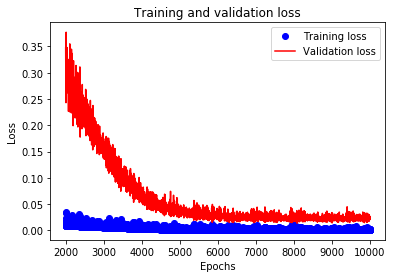

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs[2000:], loss[2000:], 'bo', label='Training loss')
plt.plot(epochs[2000:], val_loss[2000:], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test the network

This network predicts the imu error based on the learned imu error model from training samples. We predict each epoch based on the previously predicted errors.

In [51]:
#future unknown predictions: in this case, test_set doesn't exist
future_pred_count = len(testing_dlon) #let's predict 100 new steps
regressor.reset_states() #always reset states when inputting a new sequence
previous_inputs = y_lon_train
#first, let set the model's states (it's important for it to know the previous trends)
predictions = regressor.predict(previous_inputs) #this creates states
#future predictions
predicted_error = []
predict = []
currentStep = predictions[:,-1:,:]#testing_dlon[0].reshape(1,1,1)#predictions[:,-1:,:] #np.reshape(test_trajectory.lon[0] ,(1,1,1))
#predictions[:,-1:,:] #last step from the previous prediction
for i in range(future_pred_count):
    currentStep = regressor.predict(currentStep) #get the next step
    #print(currentStep)
    unnorm_error=currentStep*std_lon+m_lon
    predicted_error.append(unnorm_error) #store the future steps 
    #print(currentStep[0,0,0])
    predict.append(currentStep[0,0,0])
#after processing a sequence, reset the states for safety
regressor.reset_states()

Some smoothing functions. We do not use them, but feel free to test them.

In [53]:
# given a series and alpha, return series of smoothed points
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [54]:
def ma_smoothing(error, w):
    from pandas import Series
    series = pd.Series(error)
    rolling = series.rolling(window=w)
    rolling_mean = rolling.mean()
    return rolling_mean

We apply the errors to correct the longitude.

In [71]:
def correct_error(error):  
    bias=error[0]
    smoothed_error = ma_smoothing(error, 1)
    corrected = []  #np.array(len(error))
    smoothed_error_values = smoothed_error.values
    print(smoothed_error_values.shape)
    for i in range(smoothed_error_values.shape[0]):
        if i==0:
            corrected.append(test_trajectory.lon[i])
        else:
            corrected.append(smoothed_error_values[i]+test_trajectory.lon[i]-bias)
    return corrected

##### Visualization

(30,)


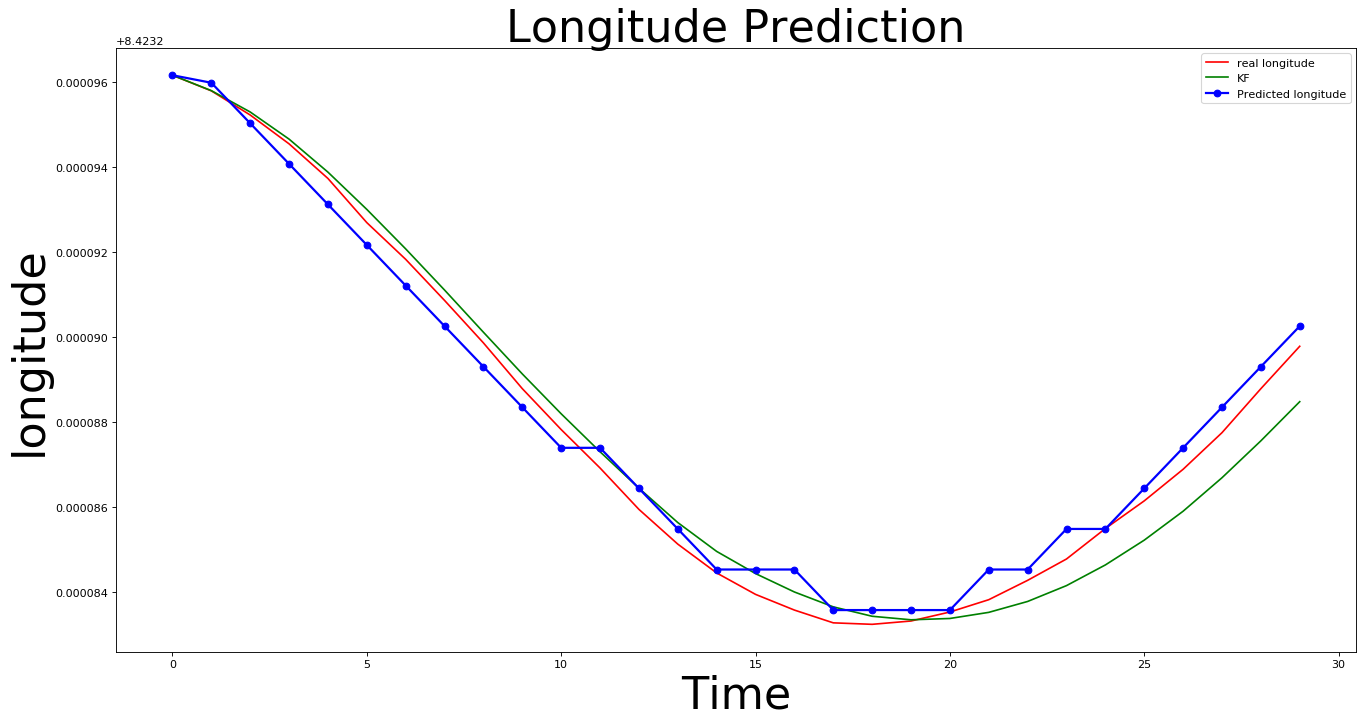

In [73]:
test_trajectory.lon[:len(test_lon_points)] - test_lon_points

plt.figure(figsize=(20, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(test_lon_points, color='red', label='real longitude')
plt.plot(test_trajectory.lon[:len(test_lon_points)], color='green', label='KF')

#alpha = 1
#bias=test_trajectory.lon[0]-future[0]
#smoothed_predict = exponential_smoothing(future+bias, alpha)
corrected = correct_error(predicted_error) 

plt.plot(corrected, 'b-o', label = 'Predicted longitude',linewidth= 2.0)


plt.title('Longitude Prediction', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('longitude', fontsize = 40)
plt.legend(loc = 'best')
plt.show()

Unfortunately, the network does not apply the smoothness constraints. A good smoothing function may improve the resutls.

### References

https://github.com/danmoller/TestRepo/blob/master/TestBookLSTM.ipynb

https://github.com/danmoller/TestRepo/blob/master/testing%20the%20blog%20code%20-%20train%20and%20pred.ipynb
https://github.com/danmoller/TestRepo/blob/master/TestBookLSTM.ipynb